<hr style="height:2px;border:none"/>
<h1 align='center'> <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />

INF-395 / 477 / 577 Tarea 2 Redes Neuronales Artificiales - 2020-2 </h1>

<H3 align='center'> Integrantes: Daniel Torres - Felipe Otero </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en tensorflow, keras, pandas y numpy
* Recurrent Neural Networks
* LSTM, GRU
* Autoencoders
* GAN

**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno para toda la tarea, con tal de que todos los entregables estén bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio en _Github_ ( en caso de ser repositorio privado, invitar como colaborador al usuario de github "Aerlio") al correo electrónico del ayudante (*<tomas.ochoa.14@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF395/477/577-2020 Tarea 2]
* Fecha de entrega y presentaciones: 8 de Enero. Hora límite de entrega: 23:00. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

[1.](#primero) RNNs para series de tiempo  <br>
[2.](#segundo) RNNs para texto <br>
[3.](#tercero) Autoencoders para imágenes <br>
[3.](#cuarto) GANs para imágenes <br>

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guías y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.

**Es ÁLTAMENTE recomendado realizar esta tarea en _Colab_ de Google (https://colab.research.google.com/notebooks/intro.ipynb#recent=true), con el fin de no depender del rendimiento de su computador personal al momento de entrenar redes neuronales y poder compartir de forma fácil sus avances con su compañer@ de trabajo.** Si bien conlleva sus pros y contras utilizar _Colab_ , existirá una curva de aprendizaje personal que lo ayudará a sacar el mayor provecho a esta herramienta, por ejemplo aprendiendo a guardar los avances realizados, evitando tener que ejecutar todo el código cada vez que se abra _Colab_ . *Tip: Una vez abierto un notebook en _Colab_ ir a **entorno de ejecución**->**Cambiar tipo de entorno de ejecución**, y seleccionár TPU como acelerador por hardware para redes recurrentes y GPU para redes convolucionales.*.

# 1. RNNs para series de tiempo

Las redes neuronales recurrentes (RNNs) son una red neuronal profunda que tiene, como su nombre indica, entradas recurrentes en la capa oculta, es decir, la salida de una capa oculta se retroalimenta a sí misma. La memoria neuronal es la capacidad impartida a un modelo para retener la entrada de los pasos de tiempo anteriores cuando la entrada es secuencial. En términos simples, cuando nuestro problema está asociado con una secuencia de datos como una oración o una serie temporal o la letra de una canción, el modelo tiene que recordar los estados previos de la entrada para funcionar.

<h1 align='center'> <img src="https://www.hobodataloggers.com.au/images/thumbs/0007371_hobo-weather-station-kits_510.jpeg" width="50%" height="100%" /> </h1>

En esta pregunta trabajaremos con datos obtenidos presumiblemente de una estación meteorológica, los cuales se obtienen desde el sitio https://www.kaggle.com/dronio/SolarEnergy, este dataset contiene mediciones de los últimos 4 meses. Nuestro objetivo será predecir el nivel de radiación solar para la próximas 24 horas.


## 1.a Carga de datos y preprocesamiento.

##### I) Iniciaremos cargando los datos. Para esto necesitará crear una cuenta en kaggle, dirigirse a su perfil, ir a Account, y en la sección API apretar _Create new API token_ , se descargará un archivo kaggle.json, ábralo como archivo de texto y obtenga su username y key. Luego ejecute el siguiente código (desconozco por qué pero a veces hay que ejecutar el código 2 veces para que funcione). Solución obtenida desde el hilo: https://gist.github.com/jayspeidell/d10b84b8d3da52df723beacc5b15cb27

In [ ]:
username="xoreza"
key="5ebc12aabb3533feca9468712151f7e6"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d dronio/SolarEnergy
if not os.path.exists("/content/solar_prediction"):
    os.makedirs("/content/solar_prediction")
os.chdir('/content/solar_prediction')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

  0% 0.00/511k [00:00<?, ?B/s]
100% 511k/511k [00:00<00:00, 74.8MB/s]
SolarEnergy.zip  SolarPrediction.csv


Procederemos a ordenar la serie temporalmente a continuación.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from pytz import timezone
import pytz

hawaii= timezone('Pacific/Honolulu') # to convert unixtime
dataset = pd.read_csv('SolarPrediction.csv') # read data
dataset = dataset.sort_values(['UNIXTime'], ascending = [True]) #sort data
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s') # make unix pandas dataframe index
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii) # convert unixtime to timestamp
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet',"UNIXTime"], inplace=True, axis=1) # drop extra-time variables
dataset.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
UNIXTime,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25


**Comentario:** Se puede observar inmediatamente que existen datos faltantes, los cuales no son declarados. Dado que de los 6 datos impresos se puede inferir que el timestep es de 5 minutos, y faltarían los datos del instante 2016-09-01 ~00:10:00 y 2016-09-01 ~00:15:00

A continuación se proveen comandos con los cuales se puede observar cómo a partir del timestamp generado se puede categorizar con comandos simples el dataset según minuto del día, hora del día, mes del año, y día del año. Los cuales se ocuparán durante la tarea. 

In [ ]:
dataset.index.minute,dataset.index.hour,dataset.index.month,dataset.index.dayofyear


(Int64Index([ 0,  5, 20, 25, 30, 45, 50, 55,  0,  5,
             ...
             10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
             ...
             23, 23, 23, 23, 23, 23, 23, 23, 23, 23],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
             ...
             12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
            dtype='int64', name='UNIXTime', length=32686),
 Int64Index([245, 245, 245, 245, 245, 245, 245, 245, 245, 245,
             ...
             366, 366, 366, 366, 366, 366, 366, 366, 366, 366],
            dtype='int64', name='UNIXTime', length=32686))

##### II) Para poder idententificar los Missing Values, y poder contar de manera segura con días de 24 horas, ejecute el siguiente código. **Explique** la funcionalidad del código escrito, escribiendo en forma de comentario (#) sobre las líneas de este código.

In [ ]:
import time
t1=time.time() 
#new_data seta la variable que definira nuestro nuevo dataset
new_data=np.nan*np.zeros((24*12*(len(np.unique(dataset.index.dayofyear))),1+len(dataset.columns)), dtype=object)
#La variable days es la encargada de obtener la cantidad de dias unicos existentes en el dataset
days=np.unique(np.asarray([str(dataset.index[i]).split(" ")[0] for i in range(dataset.shape[0])]))



#Esta funcion tal como su nombre indica, pasa la variable minutos a formato String.
def min_to_str(min):
  if min==0: min="00"
  elif min==5: min="0"+str(min)
  else: min=str(min)
  return(min)

# Aqui el codigo se ecarga de ingresar los timesteps de los dias en orden y sin detalles innecesarios como los segundos exactos, todos intervalos de 5 min
for i in range(new_data.shape[0]):
  hr=i//12-24*((i//12)//24)
  if hr==0: hr="00"
  elif 0<hr<10: hr="0"+str(hr)
  else: hr=str(hr)
  min=5*i-60*((5*i)//60)
  day=(i//12)//24
  new_data[i,0]=days[day]+" "+str(hr)+":"+min_to_str(min)+":00"


verbose,freq=True,12*24*5+12+1 # to see output
w_in=0

# Aqui el codigo se encarga de insertar los datos del dataset anterior de manera que esten bien ubicados dentro de los timesteps de nuestro nuevo dataset.
for i in range(dataset.shape[0]):
  ind=dataset.index[i]
  min=ind.minute
  if i>0: past_min=dataset.index[i-1].minute
  if i<dataset.shape[0]-1: next_min=dataset.index[i+1].minute
  if min%5!=0:
    if (min+1)%5==0: min=min+1
    elif (min-1)%5==0: min=min-1
    elif past_min%5==0:
      if past_min!=55: min=past_min+5
      else: min=0
    elif next_min%5==0:
      if next_min!=0: min=past_min-5
      else: min=55
    elif (past_min-1)%5==0:
      if (past_min-1)!=55: min=past_min-1+5
      else: min=0
    else: print(past_min,min,next_min,"---keep expanding")
  ind=str(ind)[:-11]+min_to_str(min)+str(ind)[-9:]
  found=0
  for w in range(w_in,w_in+new_data.shape[0]):
    if new_data[w,0][:-2] in ind:
      w_in=w
      found=1
      new_data[w,1:]=dataset.values[i,:]
      if verbose and i%freq==0: print(str(dataset.index[i]),"---->",new_data[w,0])
      break
  if found==0:
    print("Error at ",ind)
    break

df=pd.DataFrame(new_data[:,1:].astype("float32"),index=new_data[:,0],columns=dataset.columns)
t2=time.time()
print("Time of computation (seconds): ", t2-t1)
print("N° Missing time steps data: ", np.isnan(new_data[:,1].astype("float")).sum())
# Tal como indica posterior a su ejecucion, se aprecia que son 1300 los timesteps sin informacion.

2016-09-01 00:00:08-10:00 ----> 2016-09-01 00:00:00
2016-09-06 07:05:20-10:00 ----> 2016-09-06 07:05:00
2016-09-13 02:25:08-10:00 ----> 2016-09-13 02:25:00
2016-09-19 03:20:05-10:00 ----> 2016-09-19 03:20:00
2016-09-24 06:30:19-10:00 ----> 2016-09-24 06:30:00
2016-09-29 11:15:22-10:00 ----> 2016-09-29 11:15:00
2016-10-05 14:35:20-10:00 ----> 2016-10-05 14:35:00
2016-10-10 18:25:23-10:00 ----> 2016-10-10 18:25:00
2016-10-15 21:50:21-10:00 ----> 2016-10-15 21:50:00
2016-10-20 23:50:20-10:00 ----> 2016-10-20 23:50:00
2016-10-26 01:25:17-10:00 ----> 2016-10-26 01:25:00
2016-10-31 02:45:17-10:00 ----> 2016-10-31 02:45:00
2016-11-05 04:15:18-10:00 ----> 2016-11-05 04:15:00
2016-11-10 05:20:02-10:00 ----> 2016-11-10 05:20:00
2016-11-15 06:25:02-10:00 ----> 2016-11-15 06:25:00
2016-11-20 07:40:20-10:00 ----> 2016-11-20 07:40:00
2016-11-25 09:00:04-10:00 ----> 2016-11-25 09:00:00
2016-12-01 14:55:04-10:00 ----> 2016-12-01 14:55:00
2016-12-09 06:25:52-10:00 ----> 2016-12-09 06:25:00
2016-12-14 0

##### III) **Reemplace** TODOS los missing values (NaN) de cada columna del nuevo dataset (df) de la forma que estime conveniente. Para esto debe usar los valores respectivos de cada columna, ya sea en el pasado o futuro. <br><br> _Como ejemplo_: Si es que existen datos perdidos a las 23:15 hrs, puede reemplazar el valor NaN con el promedio entre las 23:10 y 23:20, teniendo cuidado que el valor en la columna a reemplazar p.ej Pressure sea efectivamente el promedio entre la variable Pressure a las 23:10 y 23:20 . Note que el promedio entre un valor númerico y NaN es igual a NaN, por lo que tendrá que encontrar cómo hacer frente a esta situación.  <br><br> **Comente y fundamente su elección.**

Nuestra decision de usar el promedio entre los timesteps que estan antes y despues de los NaN, se debe a que al comparar la distribucion estadistica de nuestro dataset, se puede apreciar que esta no se ve modificada en gran medida, dado que tanto el promedio como la desviacion estandar varian de manera muy pequeña, haciendo que nuestro dataset no pierda sus propiedades.

Promedio y desviacion previo a el reemplazo de NaNs
[[2.0710686e+02 3.1590527e+02]
 [5.1102985e+01 6.2010570e+00]
 [3.0422878e+01 5.4673120e-02]
 [7.5015114e+01 2.5990145e+01]
 [1.4349582e+02 8.3165054e+01]
 [6.2434602e+00 3.4901097e+00]]
Promedio y desviacion luego del reemplazo de NaNs
[[2.1189058e+02 3.1936890e+02]
 [5.1190712e+01 6.1820636e+00]
 [3.0422604e+01 5.4134130e-02]
 [7.5401421e+01 2.5758169e+01]
 [1.4256990e+02 8.3388504e+01]
 [6.2762604e+00 3.5121491e+00]]


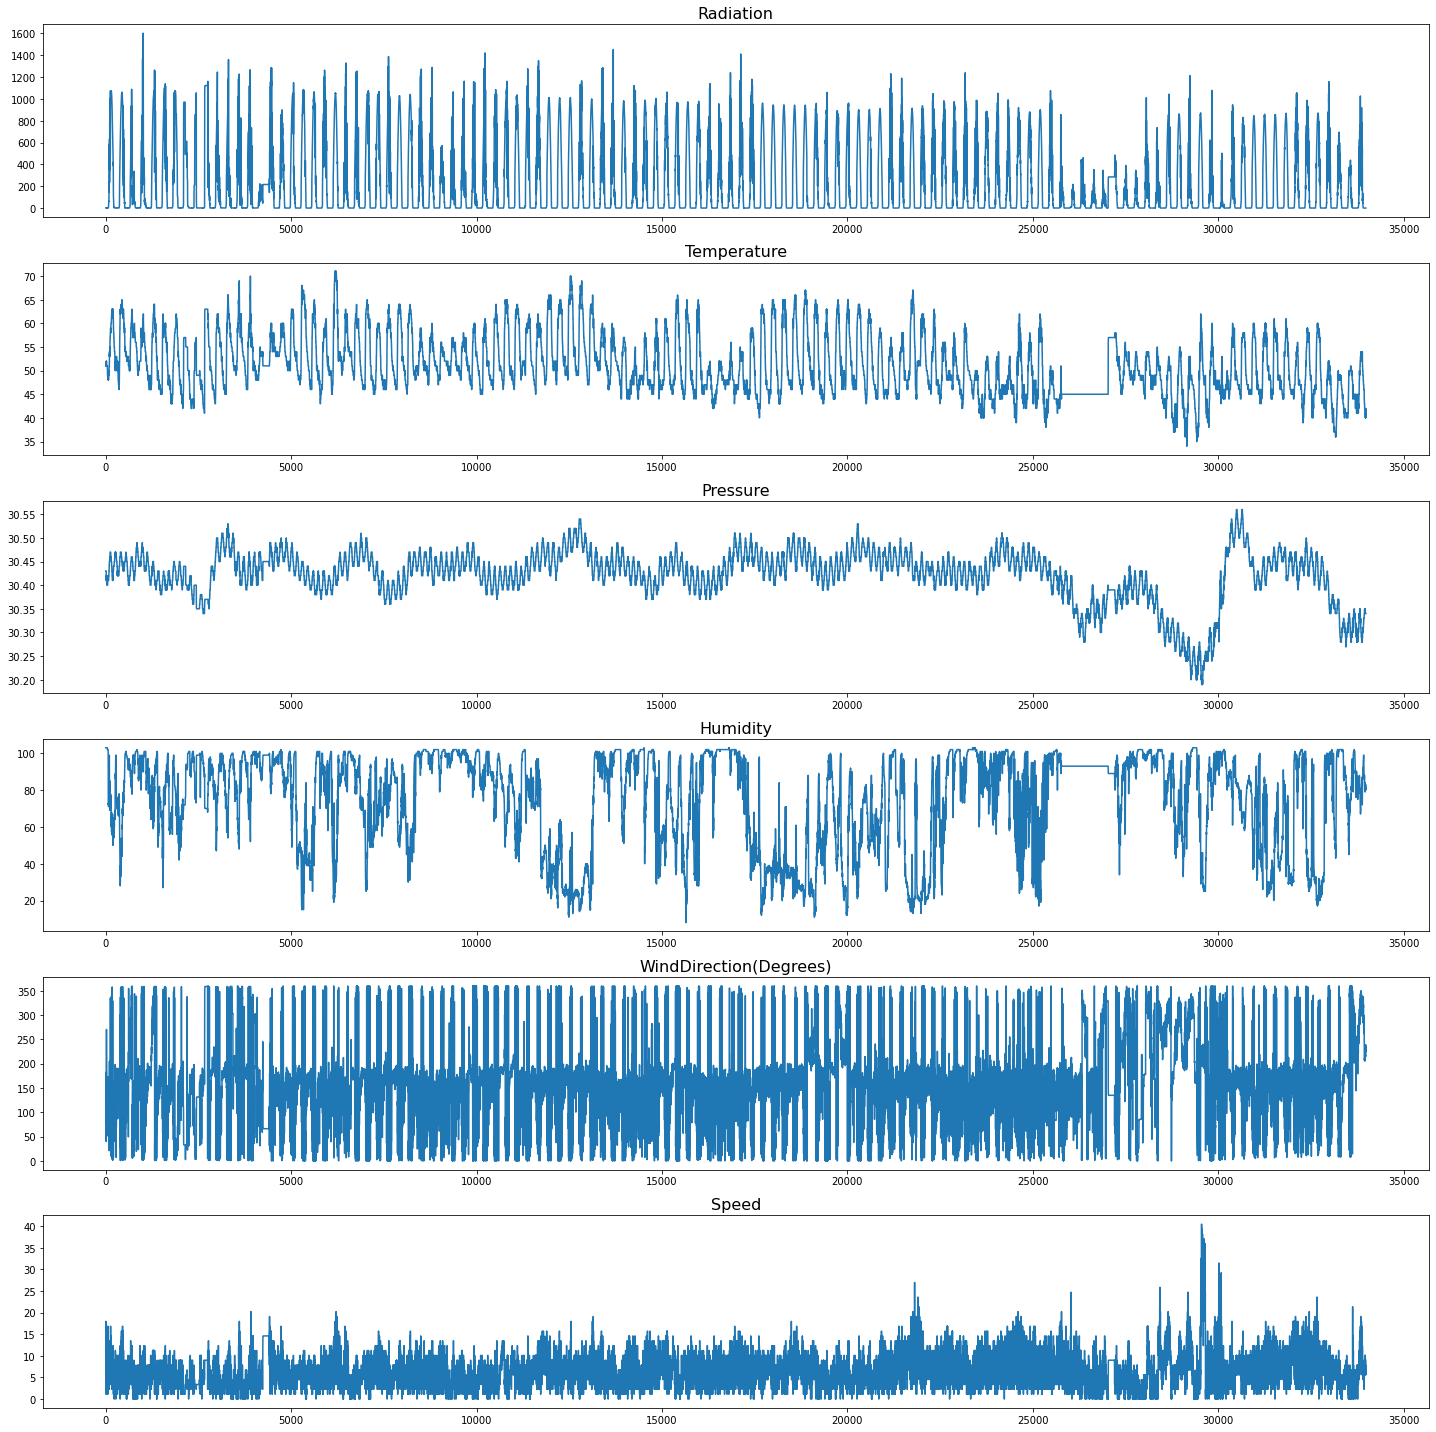

In [ ]:

time=pd.to_datetime(df.index)
var_names=df.columns.tolist()
data=df.copy().values
nan_row_loc=np.where((np.isnan((data[:,0]))==True))
np.isnan((data)).sum()

def stats(data):
  Stats= []
  for j in range(data.shape[1]):
    mean = np.nanmean(data[:,j])
    std = np.nanstd(data[:,j])
    tup = (mean,std)
    Stats.append(tup)
  return np.array(Stats)
StatsNan = stats(data) # Mean and Std by column before datafill

print("Promedio y desviacion previo a el reemplazo de NaNs")
print(stats(data))

fill_data = []
for j in range(data.shape[1]):
  value = 0
  count = 0
  for i in range(data.shape[0]):
    if not np.isnan(data[i,j]):
      value = data[i,j]
      fill_data.append(value)
    else:
      for w in range(i, data.shape[0]):
        count+=1
        if not np.isnan(data[w,j]):
          value = (value + data[w,j])/2
          fill_data.append(value)
          data[i,j] = value
          break  

NewStats = stats(data)# Mean and Std by column after datafill
print("Promedio y desviacion luego del reemplazo de NaNs")
print(stats(data))
fig, axs = plt.subplots(6,figsize=(20, 20))
for i in range(0,6):
  x = range(len(data))
  y = data[:,i]
  axs[i].set_title(var_names[i],size=16)
  axs[i].plot(x,y)
plt.tight_layout()
plt.show();

**Para disminuir los tiempos de entrenamiento reduciremos la resolución temporal de 5-min a 1-hr. Para esto calcularemos el promedio de cada hora.**

In [ ]:
data_hr=np.nan*np.zeros((int(data.shape[0]/12),data.shape[1]))
time_hr=np.nan*np.zeros((int(data.shape[0]/12)), dtype=object)
for i in range(data_hr.shape[0]):
  data_hr[i,:]=np.mean(data[12*i:12*(i+1),:],axis=0)
  time_hr[i]=time[12*i]
time_hr=pd.to_datetime(time_hr)

##### IV) **Separe** el dataset en conjuntos de entrenamiento, validación y test, para esto considere un 70% de los datos para entrenamiento, un 15% para validación y un 15% para test. Como se está trabajando con series de tiempo, proceda a crear los conjuntos de manera sucesiva. Guarde las fechas asociadas a cada dato puesto se utilizarán más adelante. 

In [ ]:
data_tr, time_tr = data_hr[:int(data_hr.shape[0]*0.7)],time_hr[:int(data_hr.shape[0]*0.7)]
data_val, time_val = data_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)],time_hr[int(data_hr.shape[0]*0.7):int(data_hr.shape[0]*0.85)]
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):int(data_hr.shape[0]*1)],time_hr[int(data_hr.shape[0]*0.85):int(data_hr.shape[0]*1)]

##### V) **Comente y visualice** los valores promedios y desviación estándar de cada atributo del dataset de entrenamiento según la hora del día y mes del año. Apóyese en el siguiente código si lo desea.

**Respuesta:** Es importante mencionar que el dataset corresponde a mediciones provenientes de **HI-SEAS** , ubicada en Big Island Hawaii  a 2.4 km sobre el nivel del mar, por lo que nos encontramos en el hemisferio norte de la tierra y la radiación debería disminuir entre septiembre y diciembre, lo que se ve reflejado en en sus promedios por mes .La dependencia temporal de los datos se ve claramente plasmada en la visualización de sus promedios durante las horas del día; la radiación junto con la temperatura alcanzan su peak entre las 10am y las 12pm, es dentro de este mismo periodo en el cual la humedad alcanza sus mínimos diarios. En terminos de velocidad del viento y la presion de aire se puede aprecial tal como se explica en este [enlace](https://sciencing.com/winds-formed-5145233.html), cambios bruscos de presion significan un aumento en la velocidad del viento, haciendo que este se mueva de sitios de mas alta presion a sitios de mas baja presion.

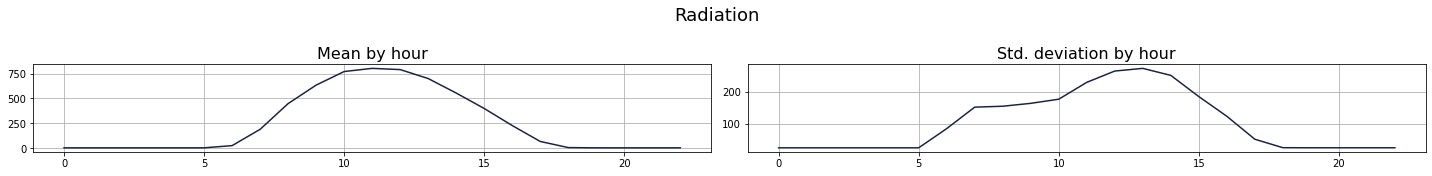

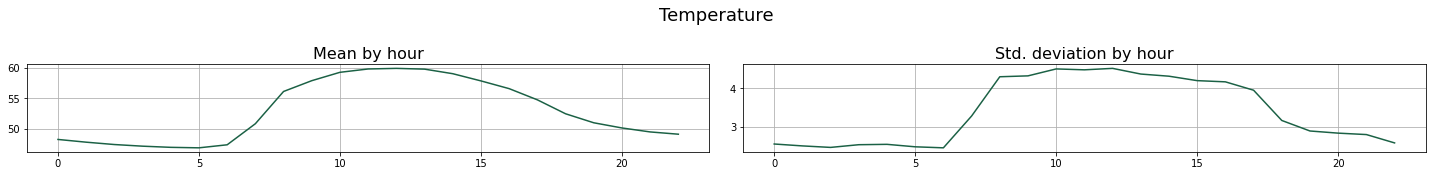

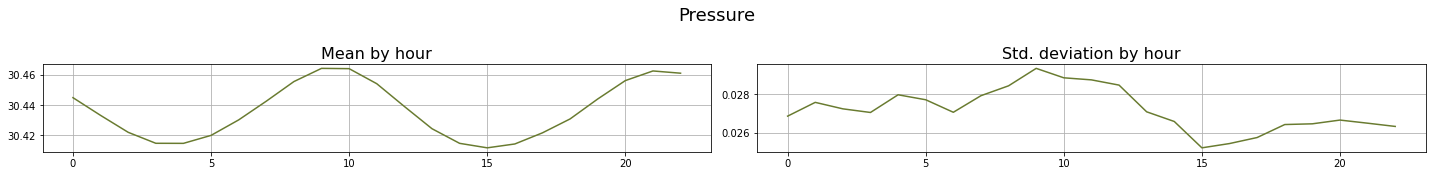

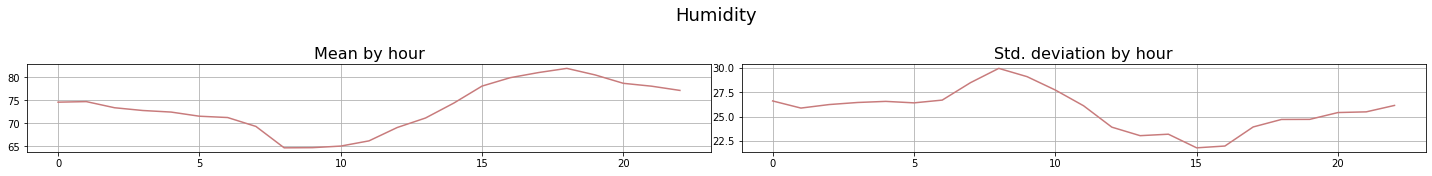

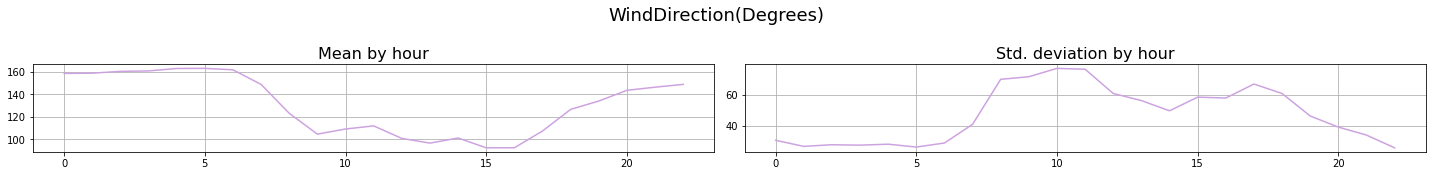

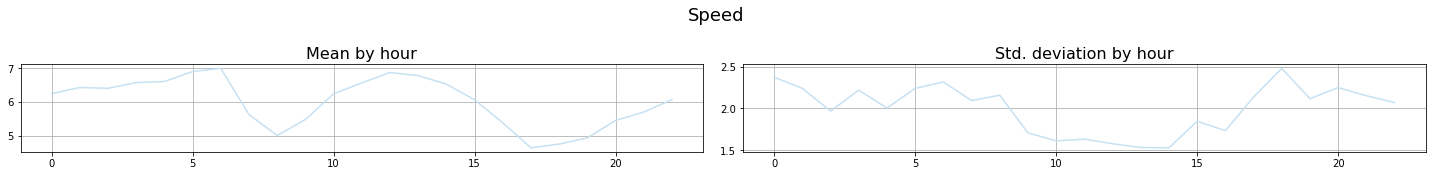

In [ ]:
import matplotlib.pyplot as plt
cols=sns.color_palette("cubehelix", len(var_names))


J=0
for i in range(6):
  var_name=var_names[J]
  mean_per_hr=np.nan*np.zeros((24))
  std_per_hr=np.nan*np.zeros((24))
  for hr in range(23):
    mean_per_hr[hr]=np.mean(data_tr[time_tr.hour==hr][:,J])
    std_per_hr[hr]=np.std(data_tr[time_tr.hour==hr][:,J])
  plt.rcParams["figure.figsize"]=[20,2]
  plt.suptitle(var_name,size=18,y=1.2)
  plt.subplot(1,2,1),plt.title("Mean by hour",size=16)
  plt.plot(mean_per_hr,color=cols[J]),plt.grid()
  plt.subplot(1,2,2),plt.title("Std. deviation by hour",size=16)
  plt.plot(std_per_hr,color=cols[J]),plt.grid()
  plt.tight_layout()
  plt.show()
  J = J+1




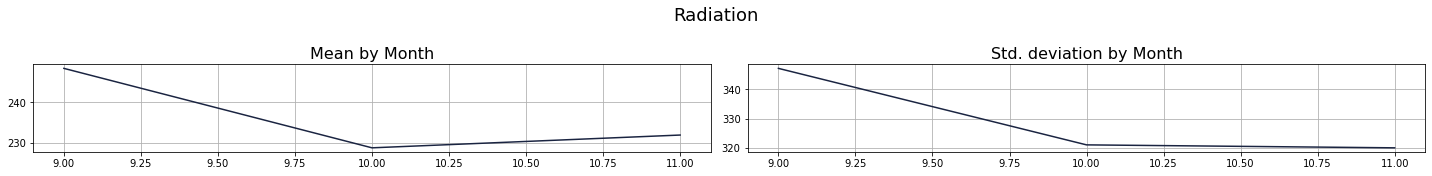

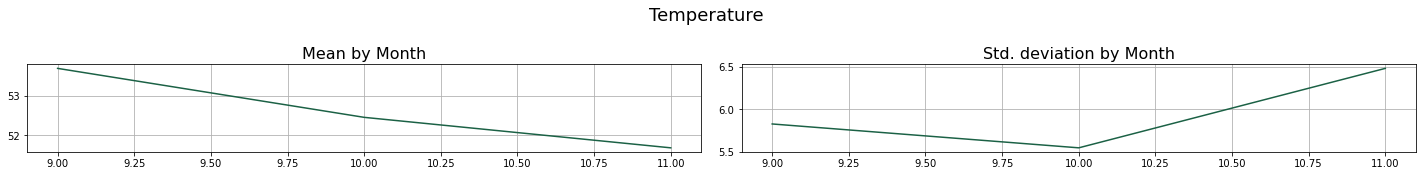

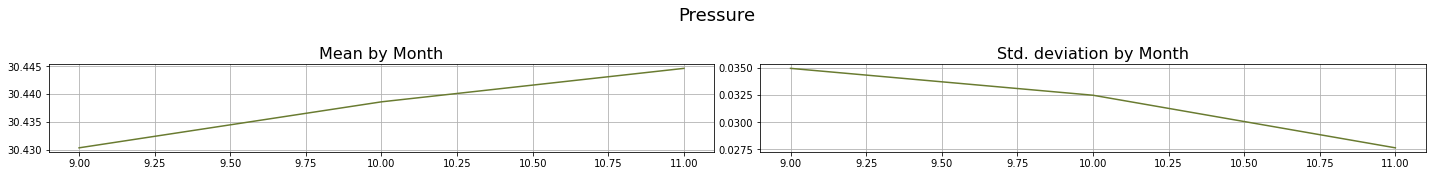

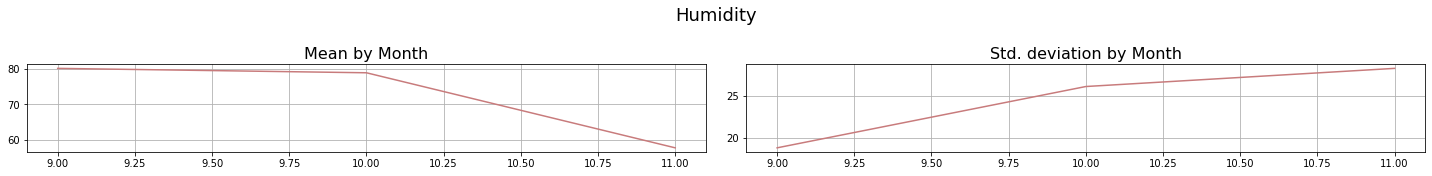

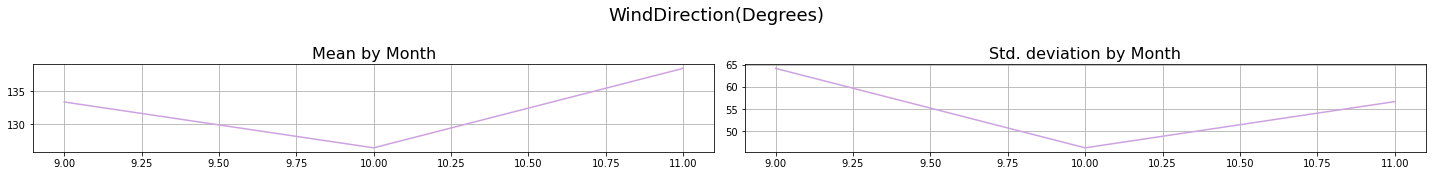

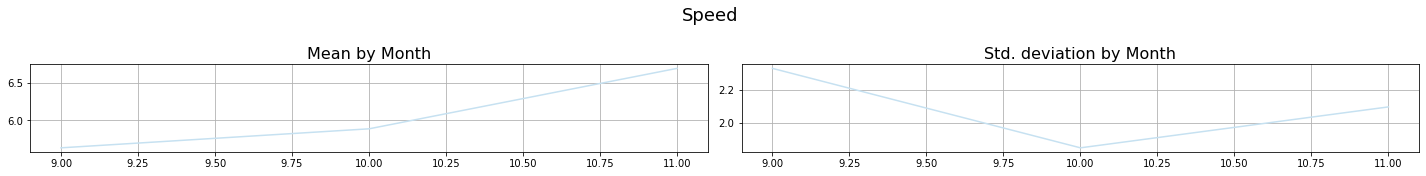

In [ ]:
cols=sns.color_palette("cubehelix", len(var_names))
J=0
for i in range(6):
  var_name=var_names[J]
  mean_per_hr=np.nan*np.zeros((12))
  std_per_hr=np.nan*np.zeros((12))
  for hr in range(9,12):
    mean_per_hr[hr]=np.mean(data_tr[time_tr.month==hr][:,J])
    std_per_hr[hr]=np.std(data_tr[time_tr.month==hr][:,J])
  plt.rcParams["figure.figsize"]=[20,2]
  plt.suptitle(var_name,size=18,y=1.2)
  plt.subplot(1,2,1),plt.title("Mean by Month",size=16)
  plt.plot(mean_per_hr,color=cols[J]),plt.grid()
  plt.subplot(1,2,2),plt.title("Std. deviation by Month",size=16)
  plt.plot(std_per_hr,color=cols[J]),plt.grid()
  plt.tight_layout()
  plt.show()
  J = J+1


##### VI) **Estandarice** los conjuntos de entrenamiento, validación y test. Tienendo en mente que buscaremos predecir la radiación para las 24 horas futuras definiremos las variables de entrada y salida, realizando una transformación conveniente utilizando la función split_sequence entregada.

In [ ]:
from sklearn.preprocessing import StandardScaler
#data_tr, data_val, data_tst
scaler = StandardScaler()
scaler.fit(data_tr)
"""codigo agregado por Felipe Otero"""
xy_tr_sc = scaler.transform(data_tr)
xy_val_sc = scaler.transform(data_val)
xy_tst_sc = scaler.transform(data_tst)

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out,time_seq):
    X, y , seq_t= list(), list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix,0]
        seq_t.append(time_seq[end_ix])
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y) , np.asarray(seq_t)

In [ ]:
len_inp=24
len_out=24
x_tr,y_tr,t_tr=split_sequence(xy_tr_sc,len_inp,len_out,time_tr)
x_val,y_val,t_val=split_sequence(xy_val_sc,len_inp,len_out,time_tr)
x_tst,y_tst,t_tst=split_sequence(xy_tst_sc,len_inp,len_out,time_tr)

**Explique** a qué corresponde cada dimensión de las variables de entrada y salida.

In [ ]:
x_tr.shape,x_val.shape,x_tst.shape,y_tr.shape,y_val.shape,y_tst.shape

((1935, 24, 6), (378, 24, 6), (378, 24, 6), (1935, 24), (378, 24), (378, 24))

* x_tr: 1935 indica la cantida de series dispuestas para su entrada, 24 indica cada timestep que en este caso son 24 dadas las 24 horas de un dia, y 6 son los campos correspondientes a los datos de cada timestep
* y_tr: En este caso son los 1935 outputs para entrenar la red y 24 son los timesteps de los cuales sera predecida la radiacion.
* x_val: Al igual que en x_tr pero en este caso solo hay 378 inputs.
* y_val: Lo mismo que y_tr pero esto siendo parte del set de validacion.

(Para el caso de x_tst e y_tst no es necesario una explicacion más detallada dado que se comportan de igual manera que lo descrito anteriormente)

* Cabe mencionar que al referirse a la cantidad de series dispuestas nos referimos la cantidad de secuencias de 24 valores de largo 6 que ingresaran a la red,Por ejemplo, x_tr posee 1935 secuencias de largo 24 con vectores $x_t \in R^6$

## 1.b) Primera  red recurrente.
Ahora entrenaremos una primera red recurrente LSTM. **Explique** la particularidad de estas redes y **por qué** podría comportarse bien para este tipo de problemas.

**Respuesta:** La particularidad de las redes LSTM consiste en que a diferencia de las RNN basicas, estas contienen algo llamado LSTM Cell, lo cual toma el papel del nodo que se utilizan en las RNN basicas pero lo vuelve un poco más complejo generando puertas de entrada que permiten al nodo elegir si que informacion conservar y que informacion olvidar de la recurrencia. La ventaja que se nos presenta por las LSTM frente a este caso, es que a pesar de lo extensas que son las secuencias de datos, se previene el desvanecimiento del gradiente.
 <br> <br> Entrenaremos dos redes recurrentes similares, la primera tan solo utilizará la variable Radiation como entrada para predecir Radiation, caso que llamaremos **univariante**, mientras la segunda utilizará las variables [Radiation, Temperature, Pressure, Humidity, WindDirection(Degrees), Speed] como entrada para predecir Radiation, caso que llamaremos **multivariante**. <br> <br> **Recupere** las funciones utilizadas en la tarea anterior para graficar los errores de entrenamiento, validación y test, y así comparar el rendimiento de ambas redes RNN gráficamente. **Comente**
 
 **Comentario:** Observando los resultados entregados, se distingue una inestabilidad del modelo multivariado, es decir, tiende a sobre ajustar rápidamente por lo que su test loss aumenta; Esto puede deberse a que el modelo multivariado sobre complejiza el problema y busca una relacion inexistente entre la radiacion respecto de los otros indicadores, en cambio el modelo univariado solo relaciona la hora del dia respecto de la radiacion percibida.

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import activations
from tensorflow.python.keras.engine import input_layer

input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_1=models.Model(inputs=input_lstm, outputs=dens)
model_1.compile(loss='mse', optimizer='adam')

model_1.summary()
history_1 = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=True) #aca ingresa todos los datos pero solo de la columna Radiacion

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
dens=layers.Dense(len_out, activation='sigmoid')(rnn)
model_2=models.Model(inputs=input_lstm, outputs=dens)
model_2.compile(loss='mse', optimizer='adam')

model_2.summary()
history_2 = model_2.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=True)# todas las columnas

y_pred_1=model_1(x_tst[:,:,0:1])
tst_loss_1=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_1)).numpy()
y_pred_2=model_2(x_tst)
tst_loss_2=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred_2)).numpy()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 56)                12992     
_________________________________________________________________
dense (Dense)                (None, 24)                1368      
Total params: 14,360
Trainable params: 14,360
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 7s 35ms/step - loss: 1.0868 - val_loss: 0.5994
Epoch 2/10
121/121 [==============================] - 4s 30ms/step - loss: 0.5984 - val_loss: 0.5071
Epoch 3/10
121/121 [==============================] - 4s 31ms/step - loss: 0.5499 - val_loss: 0.5330
Epoch 4/10
121/121 [==============================] - 4s 30ms/step - loss: 0.5343 - 

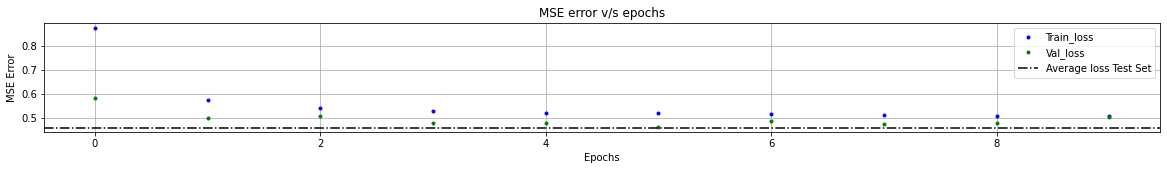

In [ ]:

plt.title("MSE error v/s epochs")
plt.plot(history_1.history["loss"],"b.",label="Train_loss")
plt.plot(history_1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss_1,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

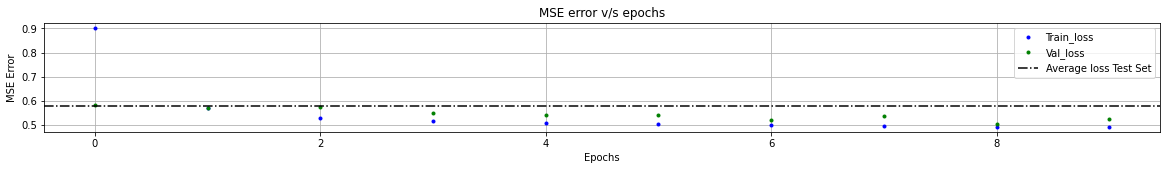

In [ ]:

plt.title("MSE error v/s epochs")
plt.plot(history_2.history["loss"],"b.",label="Train_loss")
plt.plot(history_2.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss_2,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

## 1.c) Exploración de profundidad y GRU.

##### I) Exploraremos aumentar la profundidad de la red neuronal. El modelo LSTM original se compone de una sola capa LSTM oculta seguida de una capa de salida estándar. Podríamos decir que nuestra red neuronal posee dos profundidades distintas. La Stacked LSTM es una extensión del modelo LSTM original, la cual tiene múltiples capas LSTM ocultas donde cada capa contiene múltiples celdas de memoria. A la vez, del mismo modo que en la Tarea 1, es posible aumentar la profundidad de la red densa de salida. 

Proceda a probar distintas combinaciones de profundidades de capas LSTM y de capas Densas (contando la capa de salida), para el caso univariado y multivariado. Para mantener un tiempo de ejecución produnte, considere una profunidad LSTM máxima de 2, y una profundidad densa máxima de 2. **Grafique y compare** los errores de entrenamiento, validación y test para los distintos casos.  **Comente**.

El siguiente código muestra el caso multivariado con profundidades máximas LSTM y Densas. Utilice el número de celdas de memoria y número de neuronas recomendado en el código para las distintas profundidades, al igual que el número de epochs.

**Pregunta:** ¿Por qué cuando una capa LSTM precede otra capa LSTM es necesario utilizar return_sequences=True? ¿Es necesario/recomendado utilizar return_sequences=False cuando una capa LSTM precede a una capa Densa?

**Respuesta:** Debido a que de otra manera, la capa LSTM retornaría solo el valor final $y_n$  de la secuencia de entrada, y lo que la siguiente capa LSTM requiere es una secuencia completa $y_0,y_1..y_n$. En el caso contrario una capa Densa si requiere el uso de return_sequences=False dado que esta solo requiere un output y no la secuencia completa de estos para funcionar.

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 56)                14112     
_________________________________________________________________
dense_34 (Dense)             (None, 24)                1368      
Total params: 15,480
Trainable params: 15,480
Non-trainable params: 0
_________________________________________________________________
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 24, 6)]           0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 56)                14112     
____________________________________

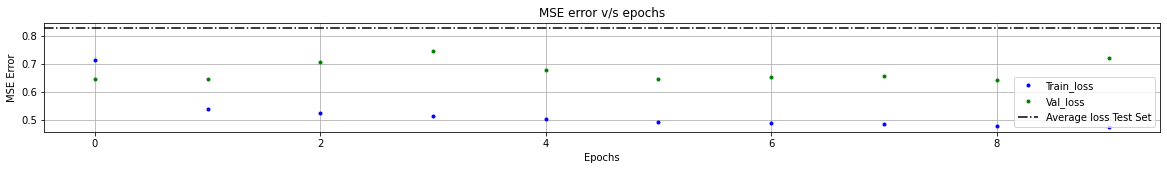

In [ ]:
his= [0,0,1,1]
hist=[]
aux = 0
for rnn_prof in his:
  input_lstm= input_layer.Input(shape=(x_tr.shape[1],1))
  if rnn_prof == 0:
    rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
  if rnn_prof == 1:
    rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm)
    rnn=layers.LSTM(units=56,return_sequences=False)(rnn)
  for j in range(2):

    if j== 0 and aux ==0: 
      dens=layers.Dense(len_out, activation='relu')(rnn)
      model=models.Model(inputs=input_lstm, outputs=dens)
      model.summary()
      aux =1
      model.compile(loss='mse', optimizer='adam')
      history = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)
      
      y_pred=model(x_tst[:,:,0:1])
      tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

      tupla = tuple((history,y_pred,tst_loss))
      hist.append(tupla)
      
      break
    if j== 1 and aux ==1:
      dens=layers.Dense(32, activation='relu')(rnn) 
      dens=layers.Dense(len_out, activation='relu')(dens)
      model=models.Model(inputs=input_lstm, outputs=dens)
      model.summary()
      aux = 0
      model.compile(loss='mse', optimizer='adam')
      history = model_1.fit(x_tr[:,:,0:1],y_tr, validation_data=(x_val[:,:,0:1],y_val), epochs=10, batch_size=16,verbose=False)
      y_pred=model(x_tst[:,:,0:1])
      tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

      tupla = tuple((history,y_pred,tst_loss))
      hist.append(tupla)
      break


                                                                   Univariado


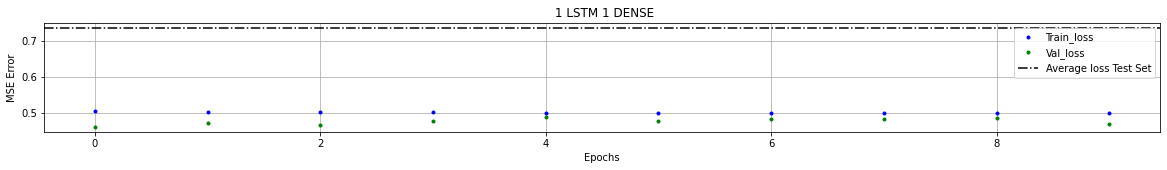

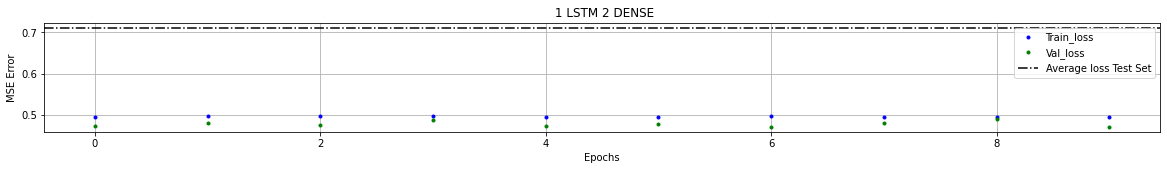

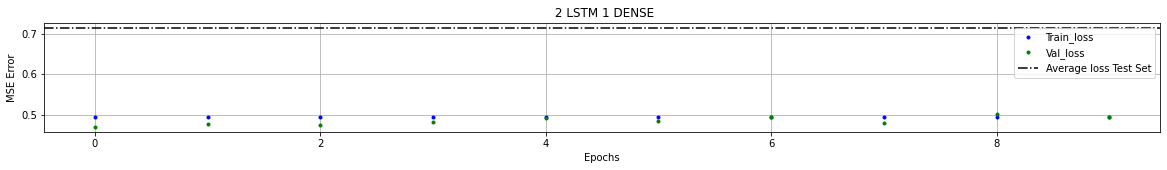

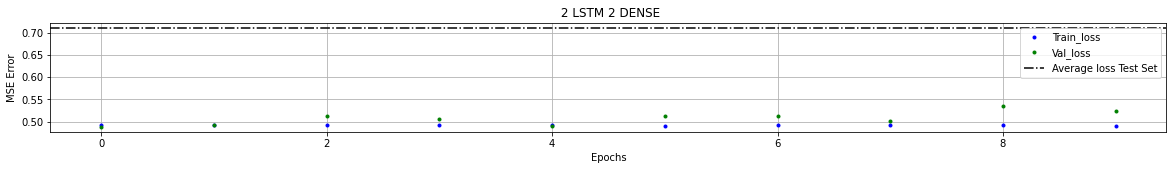

In [ ]:
print(" "*67+ "Univariado")
titles = [" 1 LSTM 1 DENSE"," 1 LSTM 2 DENSE" ," 2 LSTM 1 DENSE" , " 2 LSTM 2 DENSE"]
for i in range(4):

  plt.title(titles[i])
  plt.plot(hist[i][0].history["loss"],"b.",label="Train_loss")
  plt.plot(hist[i][0].history["val_loss"],"g.",label="Val_loss")
  plt.axhline(y=hist[i][2],color="k",linestyle="-.",label="Average loss Test Set")
  plt.xlabel("Epochs"),plt.ylabel("MSE Error")
  plt.legend(),plt.grid()
  plt.show()

In [ ]:
his= [0,0,1,1]
hist=[]
aux = 0
for rnn_prof in his:
  input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
  if rnn_prof == 0:
    rnn=layers.LSTM(units=56,return_sequences=False)(input_lstm)
  if rnn_prof == 1:
    rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm)
    rnn=layers.LSTM(units=56,return_sequences=False)(rnn)
  for j in range(2):

    if j== 0 and aux ==0: 
      dens=layers.Dense(len_out, activation='relu')(rnn)
      model=models.Model(inputs=input_lstm, outputs=dens)
      model.summary()
      aux =1
      model.compile(loss='mse', optimizer='adam')
      history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)
      
      y_pred=model(x_tst)
      tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

      tupla = tuple((history,y_pred,tst_loss))
      hist.append(tupla)
      
      break
    if j== 1 and aux ==1:
      dens=layers.Dense(32, activation='relu')(rnn) 
      dens=layers.Dense(len_out, activation='relu')(dens)
      model=models.Model(inputs=input_lstm, outputs=dens)
      model.summary()
      aux = 0
      model.compile(loss='mse', optimizer='adam')
      history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=10, batch_size=16,verbose=False)
      y_pred=model(x_tst)
      tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

      tupla = tuple((history,y_pred,tst_loss))
      hist.append(tupla)
      break

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 56)                14112     
_________________________________________________________________
dense_9 (Dense)              (None, 24)                1368      
Total params: 15,480
Trainable params: 15,480
Non-trainable params: 0
_________________________________________________________________
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 24, 6)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 56)                14112     
______________________________________

                                                                   Multivariado


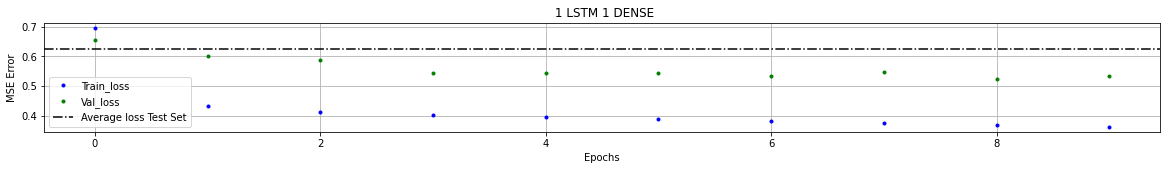

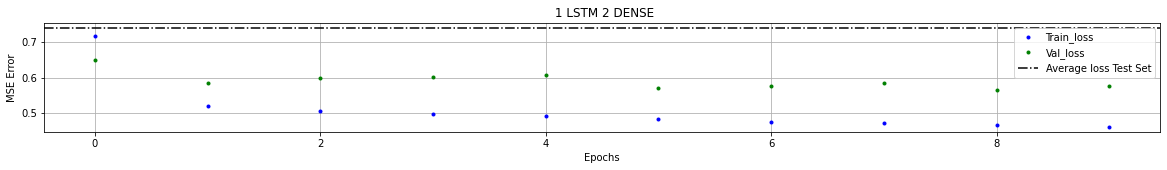

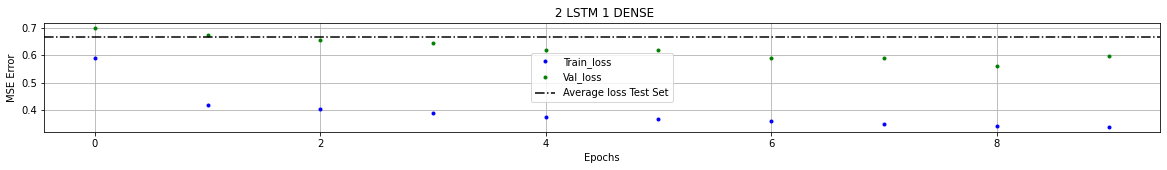

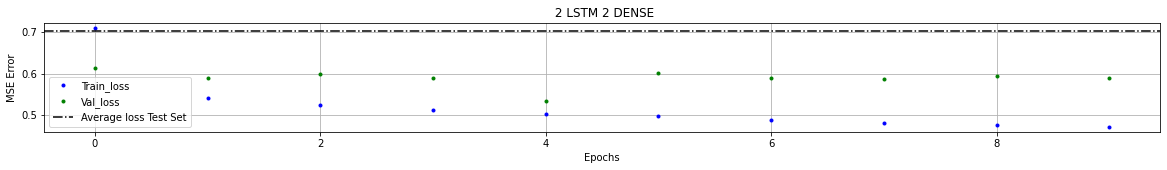

In [ ]:
print(" "*67+ "Multivariado")
titles = [" 1 LSTM 1 DENSE"," 1 LSTM 2 DENSE" ," 2 LSTM 1 DENSE" , " 2 LSTM 2 DENSE"]
for i in range(4):
  plt.title(titles[i])
  plt.plot(hist[i][0].history["loss"],"b.",label="Train_loss")
  plt.plot(hist[i][0].history["val_loss"],"g.",label="Val_loss")
  plt.axhline(y=hist[i][2],color="k",linestyle="-.",label="Average loss Test Set")
  plt.xlabel("Epochs"),plt.ylabel("MSE Error")
  plt.legend(),plt.grid()
  plt.show()

##### II) Añadiremos entradas a la capa Densa que indiquen la hora del día de forma bi-dimensional, semejante a un reloj, y una variable dummy que indica si es de día o noche. Ejecute el siguiente código para generar las entradas adicionales, y **añada la entrada** a la arquitectura entregada. Esta forma de ingresar variables adicionales a la capa densa se asemeja a la arquitectura skip-connections vista en la Tarea 1. **La hora que se entrega para indicar si es de día o noche es intencionalmente erronea**. Utilizando los datos de radiación del conjunto de entrenamiento **deberá definir las horas de día y noche de manera justificada**. 

**Comente** sobre los resultados obtenidos.

**Comentario:** Analizando la radiación por hora se determinó que cuando no es de dia , la radiacion ronda entre los $(1.2-1.5) [\frac{W}{m^2}]$, datos superiores a estos nos indican que esta ameneciendo, oscureciendo o es de día. El resultado obtenido es que, en Hawaii,entre septiembre y diciembre, es de día desde las 6am hasta las 17pm, lo se condice con los datos de la pagina [time and date](https://www.timeanddate.com/sun/usa/honolulu?month=9&year=2020) .

**Pregunta:** ¿Por qué puede resultar beneficioso representar la hora del día de manera bidimensional en lugar de unidimensional? 

**Respuesta:** 

{0, 1, 2, 3, 4, 5, 18, 19, 20, 21, 22, 23}
[6, 17]


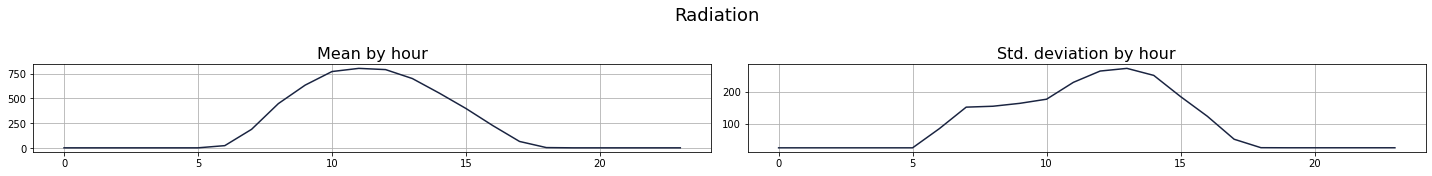

In [ ]:
daytimehrs=[2,22]
noche = set([])
J= 0
var_name=var_names[J]
mean_per_hr=np.nan*np.zeros((24))
std_per_hr=np.nan*np.zeros((24))
for hr in range(24):
  mean_per_hr[hr]=np.mean(data_tr[time_tr.hour==hr][:,J])
  for i in data_tr[time_tr.hour==hr][:,J]: 
    if i < 1.5:
      noche.add(hr)
  std_per_hr[hr]=np.std(data_tr[time_tr.hour==hr][:,J])
print(noche)
daytimehrs = [i for i in range(0,24) if i not in noche]
daytimehrs = [daytimehrs[0],daytimehrs[-1]]
print(daytimehrs)
plt.rcParams["figure.figsize"]=[20,2]
plt.suptitle(var_name,size=18,y=1.2)
plt.subplot(1,2,1),plt.title("Mean by hour",size=16)
plt.plot(mean_per_hr,color=cols[J]),plt.grid()
plt.subplot(1,2,2),plt.title("Std. deviation by hour",size=16)
plt.plot(std_per_hr,color=cols[J]),plt.grid()
plt.tight_layout()
plt.show()
J = J+1

In [ ]:
from math import *

hour_1_tr=np.asarray(np.sin(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
hour_2_tr=np.asarray(np.cos(2*pi*pd.to_datetime(t_tr).hour/24)).reshape(-1,1)
dummy_tr=(1*(pd.to_datetime(t_tr).hour<daytimehrs[1])*(pd.to_datetime(t_tr).hour>daytimehrs[0])).reshape(-1,1)
hour_1_val=np.asarray(np.sin(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
hour_2_val=np.asarray(np.cos(2*pi*pd.to_datetime(t_val).hour/24)).reshape(-1,1)
dummy_val=(1*(pd.to_datetime(t_val).hour<daytimehrs[1])*(pd.to_datetime(t_val).hour>daytimehrs[0])).reshape(-1,1)
hour_1_tst=np.asarray(np.sin(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
hour_2_tst=np.asarray(np.cos(2*pi*pd.to_datetime(t_tst).hour/24)).reshape(-1,1)
dummy_tst=(1*(pd.to_datetime(t_tst).hour<daytimehrs[1])*(pd.to_datetime(t_tst).hour>daytimehrs[0])).reshape(-1,1)



ext_tr=np.concatenate((hour_1_tr,hour_2_tr,dummy_tr),axis=1)
ext_val=np.concatenate((hour_1_val,hour_2_val,dummy_val),axis=1)
ext_tst=np.concatenate((hour_1_tst,hour_2_tst,dummy_tst),axis=1)


Model: "model_624"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_632 (InputLayer)          [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm_1264 (LSTM)                (None, 24, 56)       14112       input_632[0][0]                  
__________________________________________________________________________________________________
lstm_1265 (LSTM)                (None, 56)           25312       lstm_1264[0][0]                  
__________________________________________________________________________________________________
input_633 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________

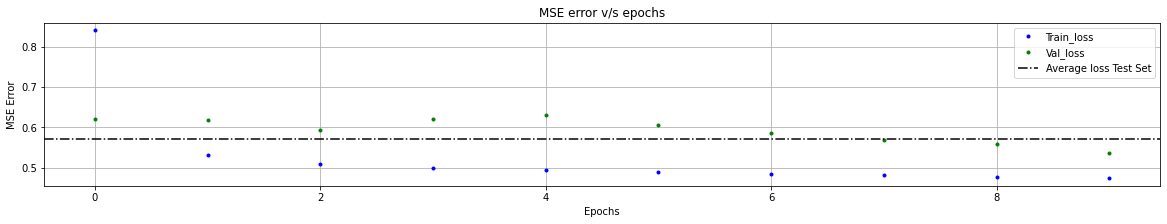

In [ ]:
from keras.layers import concatenate

input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

plt.title("MSE error v/s epochs")
plt.plot(history.history["loss"],"b.",label="Train_loss")
plt.plot(history.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

##### III) Entrene la misma arquitectura que en la pregunta anterior utilizando unidades GRU en lugar de LSTM. **Explique la diferencia entre GRU y LSTM**. **Compare** los resultados con los obtenidos en el punto anterior.

**Respuesta:** La principal diferencia entre GRU y LSTM , es que la primera no posee una puerta de olvido; Solo posee una puerta de Reset y Upadte, mientras que LSTM posee 3  puertas,llamdas puerta de entrada, puerta de olvido y puerta de salida. Esto hace que los modelos que utilicen GRU sean menos complejos, lo que se ve reflejado en la cantidad de parámetro, lo que las hace más rápidas de entrenar y utilicen menos memoria. 
Si bien las Unidades LSTM son mas lentas de entrenar, son más precisas utilizando secuencias más largas. Por lo que si nuestro problema requiere alta precision dada secuencias largas, la opción recomendad son unidades LSTM

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.GRU(units=56,return_sequences=True)(input_lstm) # 1° capa gru
rnn=layers.GRU(units=56,return_sequences=False)(rnn) # 2° gru
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 24, 56)       10584       input_7[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 56)           18984       gru[0][0]                        
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0                                            
____________________________________________________________________________________________

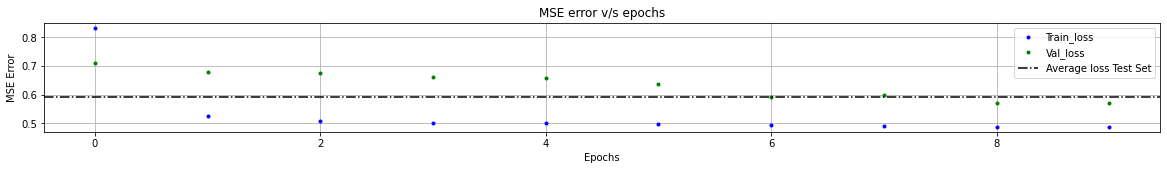

In [ ]:
plt.title("MSE error v/s epochs")
plt.plot(history.history["loss"],"b.",label="Train_loss")
plt.plot(history.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()

##### IV) Con la red con mejor rendimiento, respecto al error de validación, en este punto 1.c) ejecute el siguiente código y saque conclusiones del violin plot.

**Pregunta:** ¿Qué hace un violin plot?

**Respuesta:** Un violin plot se utiliza para visualizar la distribución de los datos junto con su densidad de probabilidad; para nuestro caso, podemos observar la distribucion de probabilidad del error entregado por el modelo que escogimos

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 24, 6)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 24, 56)       14112       input_10[0][0]                   
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 56)           25312       lstm_8[0][0]                     
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 3)]          0                                            
____________________________________________________________________________________________

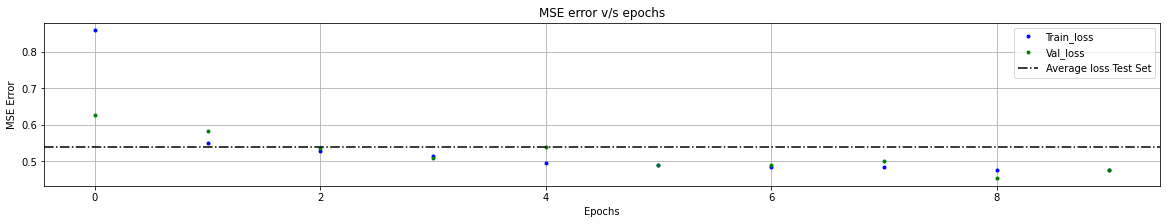

In [ ]:
input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
rnn=layers.LSTM(units=56,return_sequences=True)(input_lstm) # 1° lstm
rnn=layers.LSTM(units=56,return_sequences=False)(rnn) # 2° lstm
input_clock= input_layer.Input(shape=(3))
input_dense=concatenate([rnn, input_clock])
dens=layers.Dense(32, activation='relu')(input_dense) # 1° densa
dens=layers.Dense(len_out, activation='sigmoid')(dens) # 2° densa
model=models.Model(inputs=[input_lstm,input_clock], outputs=dens)
model.compile(loss='mse', optimizer='adam')
model.summary()
history = model.fit([x_tr,ext_tr],y_tr, validation_data=([x_val,ext_val],y_val), epochs=10, batch_size=16,verbose=True)
y_pred=model([x_tst,ext_tst])
tst_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_tst, y_pred)).numpy()


plt.title("MSE error v/s epochs")
plt.plot(history.history["loss"],"b.",label="Train_loss")
plt.plot(history.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=tst_loss,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("MSE Error")
plt.legend(),plt.grid()
plt.show()




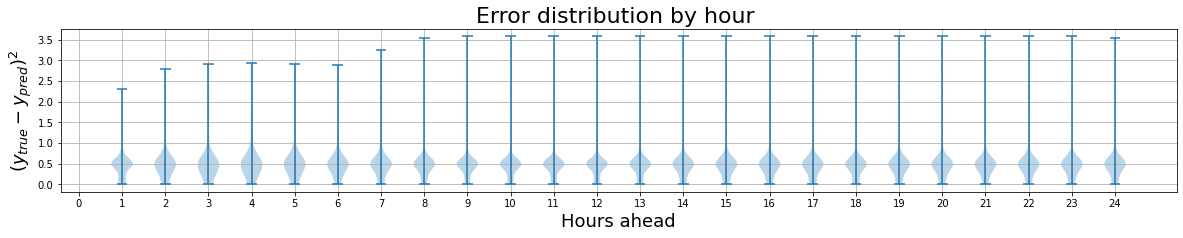

In [ ]:
tst_loss=((y_tst- y_pred)**2).numpy()
plt.rcParams["figure.figsize"]=[20,3]
plt.title("Error distribution by hour ",size=22)
plt.violinplot(tst_loss)
plt.xlabel("Hours ahead",size=18)
plt.ylabel("$(y_{true}-y_{pred})^2$",size=18)
plt.xticks(np.arange(25))
plt.grid()
plt.show()

## 1.d) Parameters & hyperparameters tunning. 

##### I) Como se habrá percatado, existe una **inmensa** cantidad de hiperparámetros que uno puede ajustar en las arquitecturas de redes neuronales (learning rate, profundidad de red, n° de neuronas en cada capa, optimizador, cantidad de epochs), también se puede considerar como hiperparámetro si es que incluir o no métodos tales como batch normalization, regularización L1/L2 o dropout en la red neuronal, a la vez habrá qué decidir dónde situar estos métodos, y cómo ajustar sus propios hiperparámetros. Aún más, también es posible experimentar con la manipulación del dataset, p.ej decidir si usar una entrada univariada, multivariada, o un punto intermedio (y si es un punto intermedio qué variables ocupar), también es posible variar el largo de las series de tiempo de entrada.

Prepare un código para hacer **Random Search**, dado que los tiempos de entrenamiento serán desproporcionados, **NO ENTRENE** las redes neuronales, pero evalúe en el conjunto de validación como si las hubiese entrenado para escoger los ""mejores"" parámetros & hiperparámetros de la red neuronal. Mantenga el objetivo de predecir la radiación para las siguientes 24 horas. **Imprima** (print) los valores de los parámetros & hiperparámetros de la red que se esté evaluando, indicando a qué corresponde, y recolecte el error de validación. Realice un Random Search de largo 100, apóyese en el código entregado, **expándalo** desde la búsqueda de 3 hiperparámetros/parámetros hasta una búsqueda de al menos **12** hiperparámetros/parámetros, puede escoger de los ejemplos dados en el primer párrafo de este ítem, o bien escoger por su propia cuenta. El código debe ser funcional, es decir, las _arquitecturas/manipulaciones del dataset_ indicadas por los hiperparámetros/parámetros deben ser efectivamente aplicadas en la construcción de la red neuronal y/o manipulación de datos. Note que en el código dado, un hiperparámetro a ajustar es recurrent dropout. **Indique** cuál fue la mejor arquitectura encontrada según el error de validación.

**Preguntas:** 

i) ¿Qué alternativas al Random Search existen? Nombre al menos una. 

Una alternativa a Random Search, es Grid Search, cuya diferencia radica en que se estable una serie de combinaciones de hiperparámetros de los cuales se busca exhaustivamente cual es la combinación óptima, este proceso de busqueda global de un óptimo es exponencialmente costoso, a mayor cantidad de hiperparámetros mayor será el tiempo de busqueda; Dada la cantidad de estos que debemos encontrar en redes recurrentes es mejor utilizar random search

ii) ¿Qué hace el método recurrent dropout?

Es un método de regularización que se aplica a las puertas update/input de las célulcas de una red recurrente, que puede ser GRU o LSTM, es una forma de desactivar la influencia de ciertas células de manera que no afecten la secuencia  proveniente de la celula anterior.

In [ ]:
kernel_ini=['random_normal','glorot_uniform','he_normal']
activation = ['sigmoid','tanh','relu']

val_h=[]
for random_search in range(100):
  act = np.random.randint(0,3)
  k = np.random.randint(0,3)
  prof_rnn=np.random.randint(1,4)
  neu_rnn=[np.random.randint(20,40) for t in range(prof_rnn)]
  rec_drop=np.random.uniform(0,0.7)


  input_lstm= input_layer.Input(shape=(x_tr.shape[1:]))
  for i,neu in enumerate(neu_rnn) :
    if i==0: rnn=layers.LSTM(units=neu_rnn[0],return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop,kernel_initializer=kernel_ini[k])(input_lstm)
    else: rnn=layers.LSTM(units=neu_rnn[i],return_sequences=(i+1<prof_rnn),recurrent_dropout=rec_drop,kernel_initializer=kernel_ini[k])(rnn)
  dens=layers.Dense(len_out, activation=activation[act])(rnn)
  model=models.Model(inputs=input_lstm, outputs=dens)
  model.compile(loss='mse', optimizer='adam')
  y_pred=model(x_val) 
  val_loss=tf.math.reduce_mean(tf.keras.losses.MSE(y_val, y_pred)).numpy()
  aux = tuple((val_loss,prof_rnn,neu_rnn,rec_drop,kernel_ini[k],activation[act]))
  val_h.append(aux)

from operator import itemgetter
val_h=sorted(val_h,key=itemgetter(0))
print("val loss,profundidad, neuronas por capa, rec drop")
print(val_h[0])



val loss,profundidad, neuronas por capa, rec drop
(0.5101596, 1, [37], 0.6512137156035688, 'random_normal', 'tanh')


##### II) Implemente sobre el código de Random Search la funcionalidad de realizar Cross-Validation con 5 Folds para cada red neuronal creada en el proceso de Random Search. Dado que se está trabajando con series de tiempo ocupe la función TimeSeriesSplit. Nuevamente **NO ENTRENE** las redes neuronales. El conjunto de entrenamiento y validación deben ser uno inicialmente para luego ser divididos en cada Fold, el conjunto de test se debiese mantener hasta el final. Calcule el error en el conjunto de validación de cada Fold y use el promedio de los 5 Folds para evaluar el rendimiento de cada red neuronal, encuentre los ""mejores"" parámetros/hiperparámetros basado en estos promedios.

**Preguntas:**

i) Visite la página https://scikit-learn.org/stable/modules/cross_validation.html . **Nombre y explique** el método TimeSeriesSplit y al menos otros 3 métodos de cross-validation. ¿Por qué time series split es adecuado para nuestro caso?

* **K-fold:** Se encarga de dividir todas las muestras en k grupos, llamados "folds" (Rn caso de k ser igual al numero de muestras, se vuelve el equivalente de utilizar la estrategia Leave One Out), de tamaños iguales si es posible. La predicibilidad es aprendida usando $k-1$ folds y el fold dejado afuera es para test, generando de esta manera grupos train/test.

* **Leave One Out (LOO):** Es una variante de K-fold donde $k=n$ siendo k el numero de folds y n la cantidad de muestras. Al igual que en k-fold la predecibilidad se entrena con $k-1$ folds dejando afuera 1 para test. 

* **Leave P Out (LPO):** Es similar a Leave One out dado que genera grupos train/test dejando fuera P elementos del conjunto generando así ${n \choose p}$ conjuntos train/test.

* **TimeSeriesSplit:** Es una variacion de K-fold, la cual se le indica la cantidad de splits que se desea hacer, y esta se encarga de conservar la relacion temporal de cada una mientras genera los splits correspondientes.

ii) ¿Cuáles son los fundamentos de Cross Validation en general (como herramienta de selección de hiperparámetros)?

Corss-Validation nos da la posibilidad de probar en un ambiente más amplio el comportamiento de nuestros hiperparametros, dejando de manera más facil y rapida la informacion sobre el comportamiento de cada uno de ellos, haciendo así la decisión de sus valores más facil.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
data_tr_val, time_tr_val = data_hr[:int(data_hr.shape[0]*0.85)],time_hr[:int(data_hr.shape[0]*0.85)] # DIVIDE IN EACH FOLD
data_tst, time_tst = data_hr[int(data_hr.shape[0]*0.85):],time_hr[int(data_hr.shape[0]*0.85):] # KEEP IT UNTIL THE END
# se debiese estandarizar en cada Fold ajustando el scaler con la data de entrenamiento que se genere

# 2. RNN sobre texto

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y tagger. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas del tipo *many to many* y *many to one*.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />


## 2.a Carga de datos y preprocesamientos


##### I) Investigue en la documentación del dataset cual es la tarea original para el cual fue propuesto, en particular cuál es la variable que buscamos predecir, a qué se refiere esta misma y por qué es necesario utilizar técnicas avanzadas para resolver esta tarea (¿no bastaría con un diccionario?).

Cargue el conjunto de datos. Este conjunto de datos es bastante grande, por lo que como ven en el código propuesto, nos contentaremos con no considerar las lineas corruptas del registro.

En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la palabra misma *word*?**

**Respuesta:** Un *lemma* es una palabra que se ubica en la cabeza de cierta definición en el diccionario, y son la palabra base de la cual derivan otro conjunto de palabras, por lo que un *lemma* nos ayuda a mejorar la generalización de nuestro modelo debido a que trabajará sobre conjunto de palabras y no sobre una palabra especifica.


In [ ]:
username="xoreza"
key="5ebc12aabb3533feca9468712151f7e6"
!pip install -q kaggle
api_token = {"username":username,"key":key}
import json
import zipfile
import os
os.environ['KAGGLE_USERNAME'] = str(username)
os.environ['KAGGLE_KEY'] = str(key)
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus
if not os.path.exists("/content/NER"):
    os.makedirs("/content/NER")
os.chdir('/content/NER')
for file in os.listdir():
    if file[-4:]==".zip":
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()
!ls

 95% 25.0M/26.4M [00:00<00:00, 115MB/s]
100% 26.4M/26.4M [00:00<00:00, 104MB/s]
entity-annotated-corpus.zip  ner.csv  ner_dataset.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

df_ner = pd.read_csv("ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
dataset = df_ner.loc[:,['lemma','tag','word','sentence_idx']]
dataset[0:21]

b'Skipping line 281837: expected 25 fields, saw 34\n'


,lemma,tag,word,sentence_idx
0,thousand,O,Thousands,1.0
1,of,O,of,1.0
2,demonstr,O,demonstrators,1.0
3,have,O,have,1.0
4,march,O,marched,1.0
5,through,O,through,1.0
6,london,B-geo,London,1.0
7,to,O,to,1.0
8,protest,O,protest,1.0
9,the,O,the,1.0


##### II) Para poder utilizar este conjunto de datos, debemos transformar nuestra tabla de palabras y sentencias, a una tabla donde cada entrada sea una sentencia, ademas codificando los distintos lemmas y tags como valores numéricos. Esto pueden realizarlo con alguna de las utilidades de keras o sklearn, sin embargo en el código siguiente se propone un metodo solo usando python y pandas. Pueden utilizar el método que deseen. Note eso si que independiente la aproximación que utilice debe comenzar desde 1 para la codificación, pues el valor 0 lo reservaremos para representar la ausencia de palabras más adelante.

**Explique qué realiza cada linea del código.**

In [ ]:
import numpy as np

tags = dataset.tag.unique()
tags = np.insert(tags,0,'0')
lemmas = dataset.lemma.unique()
print(lemmas)
print(tags)
lemma_to_code = {lemma:code+1 for code, lemma in enumerate(dataset.lemma.unique())} #transforma cada lema a un número respectivo posición en  dataset.lemma.unique()
tag_to_code = {tag:code+1 for code, tag in enumerate(dataset.tag.unique())}#transforma cada tag a un número respectivo de su posición en  dataset.tag.unique()
n_lemmas = len(lemma_to_code)

dataset['lemma'] = dataset.lemma.apply(lambda x: lemma_to_code[x]) #se aplica lemma_to_code a cada lemma en el dataset
dataset['tag'] = dataset.tag.apply(lambda x: tag_to_code[x])#se aplica tag_to_code a cada tag del dataset
print(dataset.tag.unique())
dff = dataset.groupby("sentence_idx")[['lemma','tag']].agg(list).applymap(np.asarray) #se genera una lista de todos los lemmas con sus tags asociandolos a su id de oración




['thousand' 'of' 'demonstr' ... 'mahn' '3700' 'bermel']
['0' 'O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


## 2.b) Distribuciones.

Ahora que ya tenemos las sentencias codificadas y agrupadas, explore el tamaño de estas, en número de lemmas: ¿Son todas las sentencias de igual tamaño? ¿Le hace sentido esto? ¿Las redes que conoce pueden manajar ejemplos de distintos tamaños, y si pueden qué problemas podría traer? ¿Están las clases repartidas de manera equitativa?

**Respuesta:** Las sentencias son de distinto tamaño, lo cual es natural, dado que las oraciones no son rígidas en cuanto a la cantidad de palabras que poseen por lo que si tiene mucho sentido. La implementacion de las redes recurrentes en keras si son capaces de soportar secuencias de largo dinamico pero utilizando padding y masking, padding para forzar a que las secuencias se rellenen y posean el mismo largo, y masking para dejar pasar estos valores que fueron agregados; esto último con el fin de evitar que tengan un impacto negativo en la generalización de la red. * *falta lo de las clases* *

Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?** (https://es.wikipedia.org/wiki/Ley_de_Zipf). Realice un gráfico de la cantidad de datos por clase. Comente.

**Respuesta:** Según Zipf, la frecuencia de las palabras debería seguir una distribucion que puede aproximarse por $ P \approx 1/n^a  $. Por lo que el plot de dichos datos debería tener la fórmula de una asintota hacia el eje $y$

Text(0.5, 1.0, 'Frecuencia de cada lema')

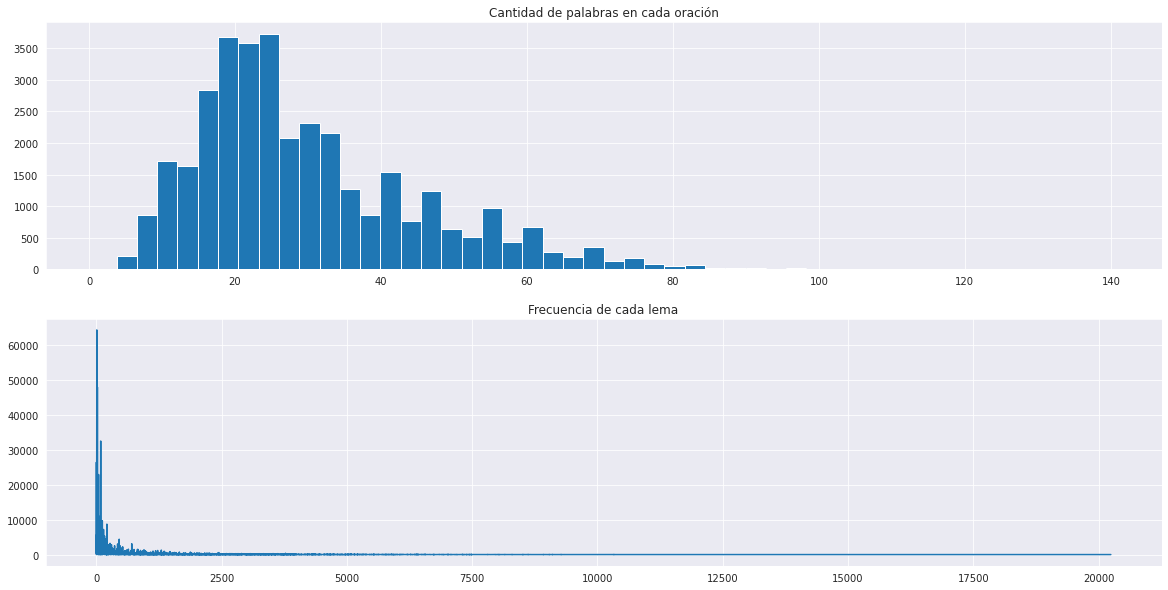

In [ ]:

import matplotlib.pyplot as plt

sentence_size =[]
lemma_frecuency = np.zeros((n_lemmas+1, ))
tag_frecuency = np.zeros((18, ))

for sentence in dff["lemma"]:

  sentence_size.append(len(sentence))
  for i in sentence:
    i = int(i)
    lemma_frecuency[i] = lemma_frecuency[i] + 1

for all_tag in dff["tag"]:
  for tag in all_tag:
    tag_frecuency[tag] = tag_frecuency[tag] +1

fig, ax = plt.subplots(2,1,figsize=(20, 10))
ax[0].hist(sentence_size, bins=50)
ax[0].set_title('Cantidad de palabras en cada oración')

ax[1].plot(lemma_frecuency)
ax[1].set_title('Frecuencia de cada lema')




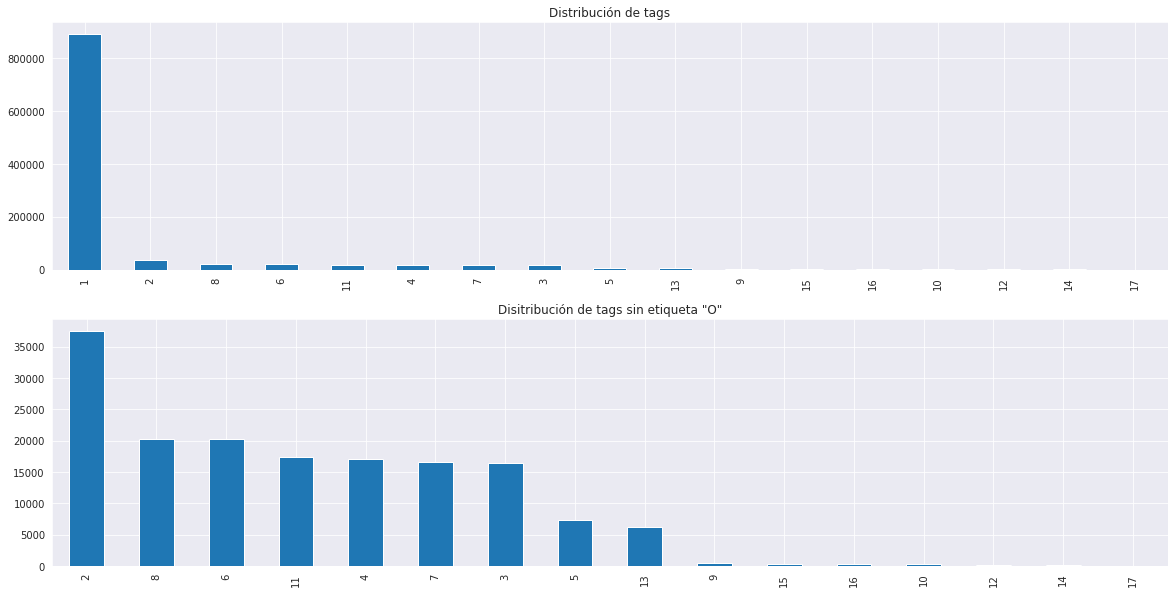

In [ ]:

fig, ax = plt.subplots(2,1,figsize=(20, 10))
dataset.tag.value_counts().plot.bar(ax=ax[0], title='Distribución de tags')
dataset[dataset.tag != 1].tag.value_counts().plot.bar(ax=ax[1], title='Disitribución de tags sin etiqueta "O"')


## 2.c) Padding y one hot vectors


##### I) En esta parte de la tarea, deben lograr que todas las secuencias de lemmas (y los tags correspondientes) queden del mismo largo, es decir realizar padding. El padding debe realizarse con el valor 0, pueden escoger si realizarlo al comienzo de la secuencia o al final, expliquen su elección. Pueden utilizar la función keras.preprocessing.sequence.pad_sequences o escribir sus propios códigos. Elija un valor de maxlen que le parezca adecuado.



¿Opinan que es deseable utilizar el valor 0 como codificación de palabras que "no existen", o creen que es irrelevante por ejemplo que su valor sea 1?

**Respuesta:** 0 es un valor adecuado, dado que el valor númerico de los lemas fueron seteados desde el 1 en adelante, por lo que 0 es un valor que esta libre de significado, si "no existen" tuviera valor 1 , chocaria con la información asoaciada al lema 1 por lo que se debería modificar la lógica de asignación numerica de los lemas.

In [ ]:
from keras.preprocessing.sequence import pad_sequences



X = np.array(pad_sequences(dff.lemma, maxlen=max(sentence_size), padding='post', value=0).tolist())
Y = np.array(pad_sequences(dff.tag, maxlen=max(sentence_size), padding='post', value=0).tolist())
n_tags = len(dataset.tag.unique()) +1 #mas 1 por el tag "no existe"


##### II) Para poder entregar una clasificación sobre los distintos *tags* es necesario transformarlos a *one hot vectors*, debido a que están codificados en números enteros, esto resultará en un arreglo tridimensional con la cantidad de ejemplos, la cantidad máxima de palabras y la cantidad de posibles *tags*. Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente

**Respeuesta:** Las dimensiones de los conjuntos pre-imagen, es decir $x$, corresponde a la cantidadde oraciones de largo 140 que hay en el conjunto, su imagen $y$, sirve para asociar cada lema dentro de cada una de esas oraciones a cierto tag.

* x_tr : $26382$ oraciones de largo $140$
* y_tr : $26382 *140$ vectores **tag** de largo $18$


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_tags) for i in Y])
x_tr, x_val, y_tr, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
x_tr.shape,y_tr.shape,x_val.shape,y_val.shape


((26382, 140), (26382, 140, 18), (8795, 140), (8795, 140, 18))

## 2.d) RNN many to many



##### I) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto, entrene y evalúe su desempeño sobre ambos conjuntos. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red no es un vector como anteriormente se ha trabajado, sino que tiene una dimensión extra la cual es debido a que en cada instante de tiempo se necesita entregar un *output*. Como los *lemmas* corresponden a datos esencialmente categóricos, o al menos discretos, es necesario generar una representación vectorial de ellas. La primera capa de la red a construir debe por lo tanto incluir una transformación entrenable desde el espacio de representación original (discreto) a ${\rm I\!R}^{d}$ , con $d$ la dimensionalidad del *embedding*. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**.

**Comentario:** La capa embedding posee la particularidad de que asignará cada lemma de cada secuencia a cierto punto en el espacio dimensional asignada a la dimension del embedding, por lo que el tensor resultante $cantidadSecuencias,largoSecuencia,EmbeddingOutput$


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
print(n_lemmas)
m = Sequential()
embedding_dim = 18
max_len=140
#n_lemmas=25000 #solo modifique la cantidad de lemas,debido a que n_lemmas era la cantdad e lemas unicos
m.add(Embedding(input_dim=n_lemmas +1, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
m.summary()
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)



20243
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 140, 18)           364392    
_________________________________________________________________
lstm_3 (LSTM)                (None, 140, 128)          75264     
_________________________________________________________________
dense_3 (Dense)              (None, 140, 18)           2322      
Total params: 441,978
Trainable params: 441,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 90s 426ms/step - loss: 0.9615 - acc: 0.8127 - val_loss: 0.2037 - val_acc: 0.9646
Epoch 2/3
207/207 [==============================] - 89s 428ms/step - loss: 0.1919 - acc: 0.9654 - val_loss: 0.1469 - val_acc: 0.9672
Epoch 3/3
207/207 [==============================] - 89s 428ms/step - loss: 0.1327 - acc: 0.9672 - val_l

Para evaluar su modelo utilice una métrica adecauda para el desbalance presente entre las clases.

In [ ]:
!pip install sklearn-crfsuite
from sklearn_crfsuite.metrics import flat_classification_report
y_pred = np.array(m(x_val))
y_pred=np.argmax(y_pred, axis=2)
y_val_t=np.argmax(y_val, axis=2)
target= np.array([i for i in range(0,18)]) 
#print(target)
print(flat_classification_report(y_val_t, y_pred,zero_division=0))
#print(flat_classification_report(y_val, np.around((y_pred),decimals=0),zero_division=1))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.93      1.00      0.96    220977
           2       0.39      0.62      0.48      9380
           3       0.00      0.00      0.00      4145
           4       0.00      0.00      0.00      4058
           5       0.00      0.00      0.00      1828
           6       0.00      0.00      0.00      5020
           7       0.00      0.00      0.00      4104
           8       0.00      0.00      0.00      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.41      0.27      0.33      4134
          12       0.00      0.00      0.00        48
          13       0.00      0.00      0.00      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

##### II) Varı́e la dimensionalidad del embedding inicial y determine si **aumenta o disminuye el error de clasificación**. Comente.

**Comentario:**  al aumentar la entrada del embedding, la red es capaz de predicir con mayor generalidad los tags de menor ocurrencia en las sentencias, y pasa de sólo predicir los tags **0** y **1**  A predecir hasta el tag **9**

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense

#¿problemas con el embedding al ejecutar? chequear que el n_lemas, n_tags, y max_len correspondan a los datos modificados con padding
m = Sequential()
embedding_dim = 64
max_len=140
#n_lemmas=25000 #solo modifique la cantidad de lemas,debido a que n_lemmas era la cantdad e lemas unicos
m.add(Embedding(input_dim=n_lemmas +1, output_dim=embedding_dim, input_length=max_len))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Epoch 1/3
207/207 [==============================] - 91s 431ms/step - loss: 0.8589 - acc: 0.8645 - val_loss: 0.1927 - val_acc: 0.9671
Epoch 2/3
207/207 [==============================] - 89s 431ms/step - loss: 0.1794 - acc: 0.9668 - val_loss: 0.1184 - val_acc: 0.9690
Epoch 3/3
207/207 [==============================] - 90s 433ms/step - loss: 0.1067 - acc: 0.9707 - val_loss: 0.0843 - val_acc: 0.9747


In [ ]:
y_pred = np.array(m(x_val))
y_pred=np.argmax(y_pred, axis=2)
y_val_t=np.argmax(y_val, axis=2)
print(flat_classification_report(y_val_t, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.95      1.00      0.97    220977
           2       0.39      0.77      0.52      9380
           3       0.00      0.00      0.00      4145
           4       0.41      0.00      0.01      4058
           5       0.35      0.02      0.03      1828
           6       0.50      0.00      0.00      5020
           7       0.32      0.00      0.00      4104
           8       0.19      0.00      0.00      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.46      0.52      0.49      4134
          12       0.00      0.00      0.00        48
          13       1.00      0.01      0.01      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

In [ ]:
i = np.random.randint(0, x_val.shape[0])
y_pred_test = m.predict(x_val[i])
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true = np.argmax(y_val, axis=-1)[i]


print("-"*30)
print(f"{'Lemma':15}{'True':5}\t{'Pred'}")
for (l, t, pred) in zip(x_val[i], y_true, y_pred_test):
  if t== 0:
    break
  print(f"{lemmas[l]:15}{tags[t]}\t{tags[pred]}")
  


------------------------------
Lemma          True 	Pred
war            O	['O']
case-by-cas    B-org	['0']
parliament     I-org	['O']
expect         O	['O']
mahmoud        B-per	['0']
care           I-per	['0']
like           O	['O']
rebuk          O	['O']
protest        O	['O']
sub-contractor O	['O']
such           O	['O']
mahmoud        B-per	['0']
sarkozi        I-per	['0']
front-runn     I-per	['0']
protest        O	['O']
reduc          O	['O']
war            O	['O']
pandem         O	['O']
cooper         O	['O']
96             O	['O']
demand         O	['O']
700            O	['O']
opportun       O	['O']
includ         O	['O']
"              O	['O']
aigl           B-geo	['0']
common         O	['O']
war            O	['O']
mahmoud        O	['0']
demonstr       O	['O']
war            O	['O']
frequent       B-org	['O']
demonstr       I-org	['O']
absolut        I-org	['O']
demand         I-org	['O']
frequent       I-org	['O']
demonstr       O	['O']
plane          O	['O']
scientist      O	

## 2.e) RNN Bidireccional y masking


##### I) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen.**Mejore la red definida en 2.d.I) utilizando una red neuronal recurrente Bidireccional**, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas* de entrada. Comente **cuál debiera ser la forma correcta de usar el parámetro *merge_mode*** (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. **¿Mejora o empeora el desempeño?** Analice.

**Respuesta:** Merge mode es un parámetro que nos permite definir la forma en la que las capas forward y backward combinan sus outputs, existen 4 formas distintas:.

* Average: Se promedia element-wise el vector salida, tambien es una forma de dar linealidad a la red

* Sum: Los vectores Output de las capas ocultas simplemente se suman, esto añade un comportamiento lineal.

* Concatenate: Mezcla las dimensiones de salida de las capas ocultas, generando un solo vector con toda la información entregada por dichas celdas, por esta razón, el output shape se duplica en su último respecto de la cantidad de unidades.

* Multiplication: se multiplican los vectores de salida, indice por indice  y retorna dicho vector

Es distinginble una mejora en el desempeño de la red, principalmente se observa una mejor distribución al momento de clasificar las clases con menor ocurrencia.

In [ ]:
from keras.layers import Bidirectional
embedding_dim = 64
model = Sequential()
model.add(Embedding(input_dim=n_lemmas +1, output_dim=embedding_dim, input_length=max_len))
layer_lstm = LSTM(units=128,return_sequences=True)
model.add(Bidirectional(layer_lstm,merge_mode="concat")) #ave , concat, sum, mul, none
model.add(Dense(18, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 140, 64)           1295616   
_________________________________________________________________
bidirectional (Bidirectional (None, 140, 256)          197632    
_________________________________________________________________
dense_4 (Dense)              (None, 140, 18)           4626      
Total params: 1,497,874
Trainable params: 1,497,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 177s 839ms/step - loss: 0.6665 - acc: 0.8991 - val_loss: 0.1610 - val_acc: 0.9669
Epoch 2/3
207/207 [==============================] - 173s 837ms/step - loss: 0.1442 - acc: 0.9673 - val_loss: 0.0825 - val_acc: 0.9760
Epoch 3/3
207/207 [==============================] - 174s 840ms/step - loss: 0.0718 - acc: 0.9791 - val_

In [ ]:
y_pred = np.array(model(x_val))
y_pred=np.argmax(y_pred, axis=2)
y_val_t=np.argmax(y_val, axis=2)
print(flat_classification_report(y_val_t, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    970677
           1       0.96      0.99      0.98    220977
           2       0.70      0.82      0.76      9380
           3       0.95      0.79      0.87      4145
           4       0.68      0.65      0.66      4058
           5       0.67      0.27      0.39      1828
           6       0.55      0.30      0.39      5020
           7       0.48      0.27      0.35      4104
           8       0.86      0.75      0.80      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.76      0.75      0.76      4134
          12       0.00      0.00      0.00        48
          13       0.93      0.07      0.13      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

In [ ]:
i = np.random.randint(0, x_val.shape[0])
y_pred_test = model.predict(x_val[i])
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true = np.argmax(y_val, axis=-1)[i]
print("-"*30)
print(f"{'Lemma':15}{'True':5}\t{'Pred'}")
for (l, t, pred) in zip(x_val[i], y_true, y_pred_test):
  if t== 0:
    break
  print(f"{lemmas[l]:15}{tags[t]}\t{tags[pred][0]}")

------------------------------
Lemma          True 	Pred
war            O	O
outlaw         O	O
construct      O	O
war            O	O
dress          O	O
calm           O	O
back           B-geo	B-geo
say            O	O
protest        O	O
$              O	O
ralli          O	O
present        O	O
such           O	O
gunship        O	O
iraq           O	O
darfur         O	O
protest        O	O
hayabullah     O	0
parol          O	O
pregnanc       O	O
famili         O	O


##### II) Recientemente se ha implementado la capa de *Masking* en las redes recurrentes en *keras*, lo cual podría traer gran ayuda gracias al *padding* que se realiza con el símbolo especial definido. Entrene la red definida en 2.d.I) y compare al utilizar esta funcionalidad de enmascarar el valor 0  en este caso para el default de la capa embedding.

**Respuesta:** La mascara incluida al la capa embedding  mejora el desempeño de la red, que ahora omite los valores de padding agregados y permitiendo que se distribuyan los pesos de manera más regular entre las capas ocultas, debido a que la cantidad de valores padding exceden ampliamente el resto de tags.


In [ ]:
from keras.layers import Bidirectional
print(n_lemmas)
m = Sequential()
embedding_dim = 18
max_len=140
#n_lemmas=25000 #solo modifique la cantidad de lemas,debido a que n_lemmas era la cantdad e lemas unicos
m.add(Embedding(input_dim=n_lemmas +1, output_dim=embedding_dim, input_length=max_len,mask_zero=True))
m.add(LSTM(units=128,return_sequences=True))
m.add(Dense(n_tags, activation='softmax'))
m.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = m.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)


20243
Epoch 1/3
207/207 [==============================] - 97s 452ms/step - loss: 0.2908 - acc: 0.8241 - val_loss: 0.1191 - val_acc: 0.8480
Epoch 2/3
207/207 [==============================] - 99s 478ms/step - loss: 0.1022 - acc: 0.8627 - val_loss: 0.0803 - val_acc: 0.8944
Epoch 3/3
207/207 [==============================] - 99s 479ms/step - loss: 0.0764 - acc: 0.8993 - val_loss: 0.0729 - val_acc: 0.9060


In [ ]:
y_pred = np.array(m(x_val))
y_pred=np.argmax(y_pred, axis=2)
y_val_t=np.argmax(y_val, axis=2)
print(flat_classification_report(y_val_t, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.00      0.00    970677
           1       0.18      0.99      0.31    220977
           2       0.45      0.83      0.58      9380
           3       0.87      0.06      0.11      4145
           4       0.56      0.09      0.16      4058
           5       0.39      0.36      0.38      1828
           6       0.42      0.06      0.11      5020
           7       0.37      0.17      0.24      4104
           8       0.85      0.67      0.75      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.49      0.78      0.60      4134
          12       0.00      0.00      0.00        48
          13       0.81      0.21      0.34      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

In [ ]:
i = np.random.randint(0, x_val.shape[0])
y_pred_test = m.predict(x_val[i])
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true = np.argmax(y_val, axis=-1)[i]
print("-"*30)
print(f"{'Lemma':15}{'True':5}\t{'Pred'}")
for (l, t, pred) in zip(x_val[i], y_true, y_pred_test):
  if t== 0:
    break
  print(f"{lemmas[l]:15}{tags[t]}\t{tags[pred][0]}")

------------------------------
Lemma          True 	Pred
rever          O	O
includ         O	O
die            B-gpe	I-per
mustafa        O	O
semi-autonom   B-per	O
lavrov         I-per	B-geo
fergana        I-per	I-per
orchestr       O	O
firm           O	O
bombmak        O	O
includ         O	O
rome           O	O
man            B-org	B-geo
rule           I-org	O
neighbor       I-org	B-per
includ         O	O
group          O	O
war            O	O
patrol         O	O
famili         O	O


## 2.f) Mejora libre

En base a lo experimentado, **intente mejorar el desempeño de las redes encontradas**, ya sea utilizando y combinando las distintas variaciones que se hicieron en los distintos ítemes, como bien alguna mejora en el pre-proceso de los datos (largo de secuencia, el tipo de *padding* o alguna otra), agregar mayor profundidad, variar el número de unidades/neuronas, utilizando otra *gate* de recurrencia (GRU o Vanilla/Simple), en https://keras.io/layers/recurrent/,  entre otras. Utilice la red entrenada, **se espera que sea la mejor de esta sección**, y **muestre las predicciones**, el *NER tager*, sobre algún ejemplo de pruebas, comente.

**Respuesta:** Todos los modelos anteriores tienen un problema en común y es la dificultad de trabajar con un dataset muy poco balanceado, lo que produce que las con mayor ocurrencia tengan un porcentaje de precisión y recall altos, mientras que los demás tag son olvidados por la red, por lo que el principal problema a resolver es este.
Se ve una clara mejora en la regularización de la red el aumentar el embedding output, que le permite a las capas ocultas procesar mayor información de cierta secuencia de entrada, por lo que se escogió un embedding dim de $100$.

La Mascara es fundamental para obviar la cantidad tremenda de valores padding que se ingresaron a los datos; la sentencia más larga era de $140$ pero la cantidad de estas sentencias era muy pequeña, por lo que la red principalmente recibe $0$ a procesar, de esta manera, el Zero Mask se vuelve fundamental en la generalización, por lo que escoge activarla.

Merge mode es establece como concat para poder procesar la mayor cantidad de infromacion de las secuencias.

Y por último, como intento de regularizar la red y mejorar la generalización de las clases menos recurrentes, se añade un recurrent dropout de $0.1$.

Esta red es la más precisa de todas, obtiene una alta precisión y recall en la mayoría de las clases y en la visualización del NER TAGER es evidente


In [ ]:
embedding_dim = 100
rate = 0.1

model = Sequential()
model.add(Embedding(input_dim=n_lemmas +1, output_dim=embedding_dim, input_length=max_len,mask_zero=True))
layer_lstm = LSTM(units=120,return_sequences=True,recurrent_dropout=rate)
model.add(Bidirectional(layer_lstm,merge_mode="concat")) #ave , concat, sum, mul, none
model.add(Dense(18, "softmax"))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['acc'])
history = model.fit(x_tr,y_tr, validation_data=(x_val,y_val), epochs=3, batch_size=128)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 140, 100)          2024400   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 140, 240)          212160    
_________________________________________________________________
dense_10 (Dense)             (None, 140, 18)           4338      
Total params: 2,240,898
Trainable params: 2,240,898
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
207/207 [==============================] - 325s 2s/step - loss: 0.2490 - acc: 0.8267 - val_loss: 0.0808 - val_acc: 0.8850
Epoch 2/3
207/207 [==============================] - 327s 2s/step - loss: 0.0701 - acc: 0.9044 - val_loss: 0.0464 - val_acc: 0.9397
Epoch 3/3
207/207 [==============================] - 321s 2s/step - loss: 0.0389 - acc: 0.9486 - val_loss: 0.

In [ ]:
y_pred = np.array(model(x_val))
y_pred_t=np.argmax(y_pred, axis=2)
y_val_t=np.argmax(y_val, axis=2)
print(flat_classification_report(y_val_t, y_pred_t,zero_division = 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    970677
           1       0.18      0.99      0.31    220977
           2       0.83      0.82      0.83      9380
           3       0.94      0.91      0.92      4145
           4       0.78      0.76      0.77      4058
           5       0.78      0.58      0.67      1828
           6       0.74      0.54      0.62      5020
           7       0.61      0.48      0.54      4104
           8       0.86      0.86      0.86      5000
           9       0.00      0.00      0.00       100
          10       0.00      0.00      0.00        64
          11       0.78      0.79      0.79      4134
          12       0.00      0.00      0.00        48
          13       0.83      0.48      0.61      1494
          14       0.00      0.00      0.00        66
          15       0.00      0.00      0.00        96
          16       0.00      0.00      0.00        83
          17       0.00    

In [ ]:
i = np.random.randint(0, x_val.shape[0])
y_pred_test = model.predict(x_val[i])
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true = np.argmax(y_val, axis=-1)[i]
print("-"*30)
print(f"{'Lemma':15}{'True':5}\t{'Pred'}")
for (l, t, pred) in zip(x_val[i], y_true, y_pred_test):
  if t== 0:
    break
  print(f"{lemmas[l]:15}{tags[t]}\t{tags[pred][0]}")

------------------------------
Lemma          True 	Pred
west           B-geo	B-gpe
rule           O	O
taleban        O	O
ehud           B-per	B-per
semi-autonom   I-per	O
bhutto         I-per	I-per
nawaz          I-per	I-per
expect         O	O
war            O	O
continu        O	O
demonstr       O	O
war            O	O
.              O	O
rule           O	O
german         O	O
longer         O	O
muslim         O	O
southern       O	O
allow          O	O
movement       O	O
islam          O	O
agreement      O	O
denounc        O	O
rule           O	O
saturday       O	O
insult         O	O
fair           O	O
demand         O	O
voic           O	O
famili         O	O
west           B-geo	B-gpe
rule           O	O
taleban        O	O
ehud           B-per	B-per
semi-autonom   I-per	O
bhutto         I-per	I-per
nawaz          I-per	I-per
expect         O	O
war            O	O
continu        O	O
demonstr       O	O
war            O	O
.              O	O
rule           O	O
german         O	O
longer         O

## 2.g) Escribamos palabras


##### I) Ahora buscaremos otra aplicación a las redes recurrentes, predecir el caracter siguiente. Si logramos entrenar una red que sea buena en esta tarea, podremos escribir texto automáticamente, pues podemos, a partir de una frase, predecir el caracter siguiente, y luego introducir la nueva frase sin el primer caracter en la red nuevamente, e iterando así escribir automáticamente. Si bien las redes recurrentes son adecuadas para esta tarea, no pretendemos entrenar un Shakespeare en esta tarea, sin embargo es interesante investigar qué tan verosimil o no puede lograr ser el texto generado.

Para esto, primero crearmos nuestro nuevo dataset. Para esta tarea preferiremos unir todas las frases en un solo gran corpus y luego crear nuevas secuencias semi redundantes. Esto nos evita primero el problema de tener que hacer padding, pues crearemos todas las entradas iguales, pero también nos permite aprovechar mejor el dataset, de cierta forma aumentando el número de datos. El target en este caso será solo el caracter siguiente correspondiente a cada secuencia.

En este item debe cargar el dataset. **Explique lo que hace el código entregado**

In [ ]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical

df_w = pd.read_csv(os.path.join("ner.csv"), engine='python', error_bad_lines=False)
df_w = df_w.dropna()[['word']]

corpus = ' '.join(list(df_w.word.values)).lower()
sentence_length = 40
steps = 5

sentences = []
next_char = []
for i in range(0,len(corpus) - sentence_length - 1 , steps):
  sentences.append(corpus[i:sentence_length+i])
  next_char.append(corpus[sentence_length+i])

chars_to_code = {char:code for code, char in enumerate(set(corpus))}
code_to_chars = {code:char for char,code in chars_to_code.items()}
x = np.array([[chars_to_code[char] for char in sentence] for sentence in sentences])
y = np.array([chars_to_code[char] for char in next_char])
y = to_categorical(y)

NameError: ignored

##### II) Entrene ahora una red con estos datos utilizando GRU. El resto de la estructura queda a su elección. Evalúe el desempeño de su red evaluando qué tan bien genera texto, puede utilizar las funciones propuestas como callback para ver como progresa su red. Pruebe a lo menos 2 estructuras distintas.

Una vez esté satisfecho de su red, hágala escribir algunos textos a partir de textos semilla elegidos por usted. Describa sus observaciones. ¿Qué cree ocurriría si entrenamos la red con otro dataset?

In [ ]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import sys

def predict_char(model, sentence):
    x = [chars_to_code[char] for char in sentence]
    x = pad_sequences([x], maxlen=sentence_length, padding='pre', value=0)
    probas = model.predict(x)[0]
    next_index = np.random.choice(len(chars_to_code), p=probas)
    return code_to_chars[next_index]

def on_epoch_end(epoch, logs):
    print(f'\n Generating random text for epoch: {epoch}')
    start_index = random.randint(0,x.shape[0]-1)
    sentence = ''.join([code_to_chars[code] for code in x[start_index]])
    print('\n Generating with seed: ' + sentence)
    sys.stdout.write(sentence)
    for i in range(400):
        next_char = predict_char(character, sentence)
        sentence = sentence[1:] + next_char #for next character
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

print_text_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
character = Sequential()
embedding_dim = 100
character.add(Embedding(input_dim=y.shape[1], output_dim=embedding_dim, input_length=x.shape[1]))
character.add(GRU(128,return_sequences=False))
character.add(Dense(y.shape[1],activation='softmax'))
optimizer = RMSprop(lr = 0.01)
character.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=["acc"])
character.fit(x,y, epochs=1, batch_size = 512,callbacks=[print_text_callback])
character.summary()

2371/2371 [==============================] - 664s 279ms/step - loss: 1.8805 - acc: 0.4494

 Generating random text for epoch: 0

 Generating with seed: ill let nato take armored vehicles throu
ill let nato take armored vehicles throunts and afgimbair attackial last milled by the lirate taxiy . low millanian goverder troogil incrovistast on thoir . colfor iraqi al-ahter milliod for talks awdage . the ritil limel oic no coplle tal3s millions . gaza . last . talkskine adbal talebanialy a since will folloo . la guor 's last alount . mr. . there that militacim fastrial mightions than militacy . insistane startees insorean thabu maModel: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 40, 100)           6000      
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
______________

# 3. Autoencoders en Fashion MNIST

Si bien las redes neuronales han tenido desempeños sorprendentes en muchas áreas donde antes solo un ser humano podía alcanzar buenos desempeños, uno de sus desventajas suele serla alta dimensionalidad de los espacios de hipótesis. En la práctica, esto implica que para aprender una tarea predictiva con alguna capacidad de generalización, se requieren grandes bases de datos etiquetadas. Esto implica un problema, considerando que al momento de buscar la base de datos, no se tiene a priori una manera de automatizar esta etiquetación. Esta necesidad de gran cantidad de trabajo de clasificación realizado por humanos, ha engendrado soluciones ingeniosas, como la aproximación de _Facebook_ hace algunos años de pedirle a los mismos usuarios que etiquetaran a las personas en sus fotos, o la solución de _Amazon_, _Mechanical Turk_, donde cualquier usuario puede realizar tareas repetitivas de clasificación a cambio de dinero real, o por otro lado cualquier persona puede comprar la etiquetación de una base de datos la cual realizan varias personas en cualquier parte del mundo. 

Otra aproximación, quizás aún más ingeniosa, para solucionar el problema de las etiquetas, es utilizar las bases de datos sin preocuparse de sus etiquetas. Esta aproximación de aprendizaje no supervisado tiene su representante en redes neuronales en los _Autoencoders_, redes que utilizan el mismo input como target y buscan representaciones de menor dimensionalidad al interior de la red. Estas redes han permitido el uso de cantidades masivas de datos para aprender de ellos sin necesidad de tener etiquetas. Durante esta pregunta veremos algunos de los aspectos y posibilidades básicas que nos presentan los _autoencoders_, utilizando una base de datos de imágenes de articulos de vestimenta, el Fashion MNIST. 

## 3.a) Carga de datos y visualizaciones
Cargue los datos. Puede user las funciones de `keras.datasets` como muestra el código o descargarlo manualmente. 

Luego, visualice algunas imagenes de cada una de las catégorias junto con sus nombres (investigue un poco para encontrar la codificación de `y`). Note que las imagenes deben representarse en blanco y negro, puede usar `cmap='Greys'`. ¿Qué pares de categorías cree podrían ocasionar problemas al momento de clasificación? ¿Qué tan bien cree que se desempeñaría un humano en esta tarea?

* **Respuesta**: Clase 6 con Clase 2 y Clase 4; Clase 7 con Clase 9;
Un humano es capaz de aprender rápidamente a clasificar las prendas de vestir , con una precisión muy alta, pero una velocidad baja.

4423680/4422102 [==============================] - 0s 0us/step


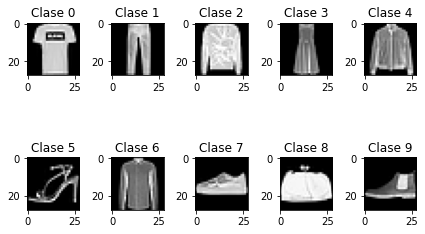

(60000, 28, 28)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
(x_tr,y_tr),(x_val,y_val) = fashion_mnist.load_data()
c = 0
j=0
k=0
fig, axs = plt.subplots(2,5)
for i in range(len(y_tr)):
  if y_tr[i] == c:
    axs[j,k].set_title('Clase ' + str(c))
    axs[j,k].imshow(x_tr[i,:,:], cmap='gray', vmin=0, vmax=255)
    c+=1
    if k == 4:
      if j == 1:
        break
      j = j+1
      k = 0
    else:
      k+=1
plt.tight_layout()
plt.show()
np.shape(x_tr)

## 3.b Posibilidades de preprocesamiento y pequeños análisis. 

Las primeras redes que entrenaremos utilizarán arquitecturas _fully connected_, por lo cual también es necesario transformar nuestras imagenes 2-dimensionales a vectores, como muestra el ejemplo de código.

**Preguntas:**

i) ¿Cuáles son los rangos de valores de `x`? ¿Por qué?

Los Rangos de `x` se encuentran entre $[0,255]$, dado que este es el rango que maneja la escala de grises, siendo $0$ negro y $255$ blanco.

ii) ¿Las distintas clases de ejemplos están balanceadas?

Todas las clases estan balanceadas

iii) ¿Considera necesario realizar un preprocesamiento? Escale los valores de `x` al intervalo $[0,1]$, y guarde el conjunto de datos original de igual manera que el escalado. ¿Se pierde información al realizar este preprocesamiento? 

Considero necesario el preprocesamiento dado que hace la tasa de convergencia mucho más rapida. No se pierde informacion dado que las cifran trabajadas por el dataset no generan la perdida de digitos significativos al momento de escalar.


Rango de x_tr_vector =  [0, 255]
Rango de x_val_vector =  [0, 255]
Rango de x_tr_vector_scaled =  [0.0, 1.0]
Rango de x_val_vector_scaled =  [0.0, 1.0]


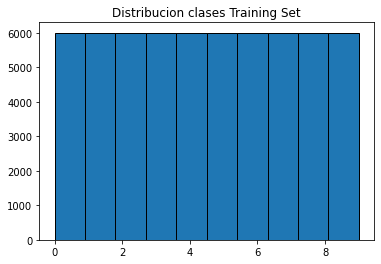

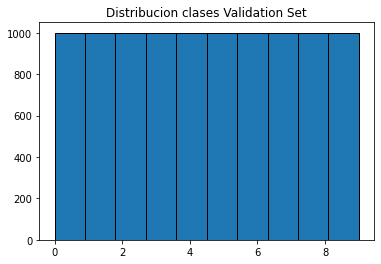

In [ ]:
from sklearn.preprocessing import MinMaxScaler

x_tr_vector = x_tr.reshape(-1,28*28)
x_val_vector = x_val.reshape(-1,28*28)
x_tr_vector_scaled = np.copy(x_tr_vector)/255.0
x_val_vector_scaled = np.copy(x_val_vector)/255.0
print("Rango de x_tr_vector = ",[np.min(x_tr_vector),np.max(x_tr_vector)])
print("Rango de x_val_vector = ",[np.min(x_val_vector),np.max(x_val_vector)])
print("Rango de x_tr_vector_scaled = ",[np.min(x_tr_vector_scaled),np.max(x_tr_vector_scaled)])
print("Rango de x_val_vector_scaled = ",[np.min(x_val_vector_scaled),np.max(x_val_vector_scaled)])
plt.hist(y_tr,ec='black')
plt.title('Distribucion clases Training Set')
plt.show();
plt.title('Distribucion clases Validation Set')
plt.hist(y_val,ec='black')
plt.show();

## 3.c) Primer Autoencoder

Entrenaremos un primer autoencoder de una capa oculta, usando arquitectura densa. Para esto, utilize como guía los códigos presentados abajo. 

Utilice en primera instancia su conjunto de datos escalados. Considerando el intervalo de los datos escalados.

Entrene esta primera red utilizando pérdida _binary cross entropy_. Compare luego las imagenes originales con las imagenes reconstruidas, como muestra el código. **Grafique** como varia la pérdida a lo largo del entrenamiento y visualice algunas imagenes reconstruidas. 

**Preguntas:**

i) ¿Qué función de activación correspondería a la capa de salida de la red? ¿Debería afectar la elección de la función de activación de la capa oculta? 

Tal como se indica en este [enlace](https://medium.com/@sakeshpusuluri123/autoencoders-52c81a6f1ae1), dado que el input data es un valor en el rango $[0,1]$, la activacion de el encoder y el decoder debe ser sigmoide, dado que su recorrido es exactamente el rango en el cual estamos trabajando.

ii) ¿Qué le parece el desempeño de la red, logra aprender la tarea en su opinion?

Segun lo observado en la forma de retornar las prendas, el autoencoder se encarga de omitir detalles y enfocarse en patrones generales de cada clase, haciendo que su funcion de clasificador sea efectiva.

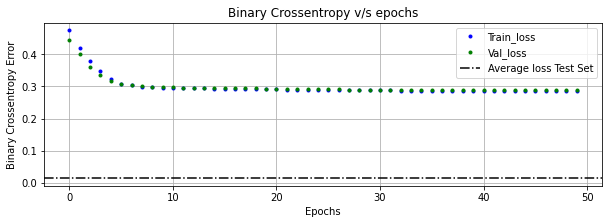

Elementos pasados por el Decoder


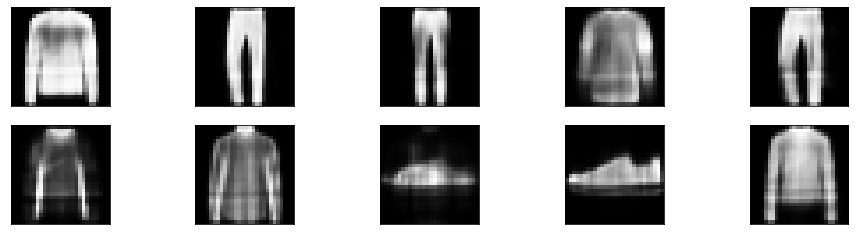

In [ ]:
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.models import Sequential
import tensorflow as tf

autoencoder = Sequential()

autoencoder.add(Dense(32,activation='sigmoid')) # encoder
 
autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

autoencoder.compile(optimizer=Adam(),loss='binary_crossentropy')
history_1 = autoencoder.fit(x_tr_vector_scaled,x_tr_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled),verbose=0)

y_pred=autoencoder.predict(x_tr_vector_scaled) # model.predict(x_test) returns numpy array
test_batch_loss=tf.keras.losses.MSE(x_tr_vector_scaled, y_pred)
test_loss_1_b_i=tf.math.reduce_mean(test_batch_loss).numpy()
plt.rcParams["figure.figsize"]=[10,3]
plt.title("Binary Crossentropy v/s epochs")
plt.plot(history_1.history["loss"],"b.",label="Train_loss")
plt.plot(history_1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=test_loss_1_b_i,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("Binary Crossentropy Error")
plt.legend(),plt.grid()
plt.show()
print("Elementos pasados por el Decoder")
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(5):
  for v in range(2):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix].reshape(28,28),cmap='gray')
    ix += 1
plt.show()

In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


## 3.d) Dimensionalidad

Una forma de interpretar lo que realiza el autoencoder, es considerar que si el autoencoder hace bien su tarea, la información necesaria para reconstruir la imagen original se encuentra en la capa oculta, la cual tiene menor dimensionalidad que la imagen original. Uno puede considerar por lo tanto que la capa de _encoding_ esta comprimiendo la información contenida en la imagen, mientras la capa de _decoding_ hace el proceso contrario, descomprimiendola a su estado original lo mejor posible. 

Explore como cambia el desempeño de la red en cuestión frente a cambios en la dimensión de la capa oculta. Pruebe a lo menos 5 niveles de compresión distintos, incluyendo uno donde la capa oculta tenga $50\%$ de ratio de compresión y otro donde la capa oculta tenga tan solo 2 neuronas. ¿Qué observa?

Que al usar una compresion de 2 neuronas no tiene sentido alguno dado que el autoencoder retorna solo ruido y no reconstruye lo que necesitamos, y que a partir del valor 32 observado anteriormente la convergencia comienza desde un Binary Crossentropy de $0.3$ a converger a valores cercanos $0.25$ quedandose en ese rango.

Compresion =  2.0


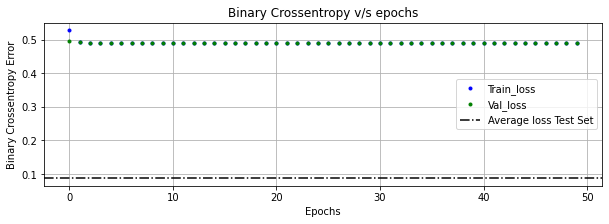

Elementos pasados por el Decoder


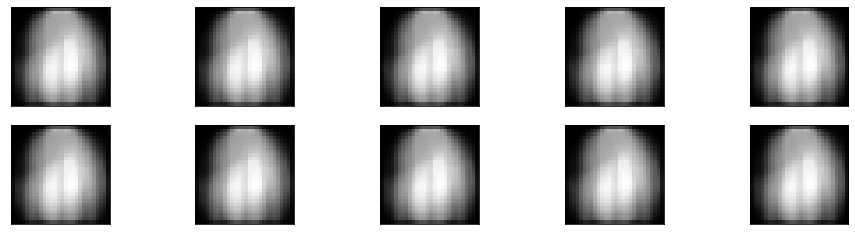

Compresion =  80.0


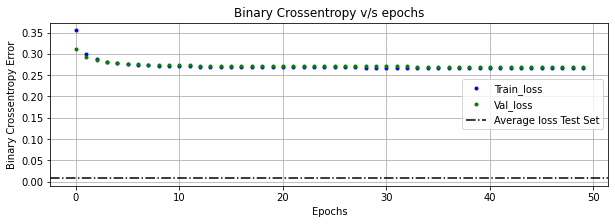

Elementos pasados por el Decoder


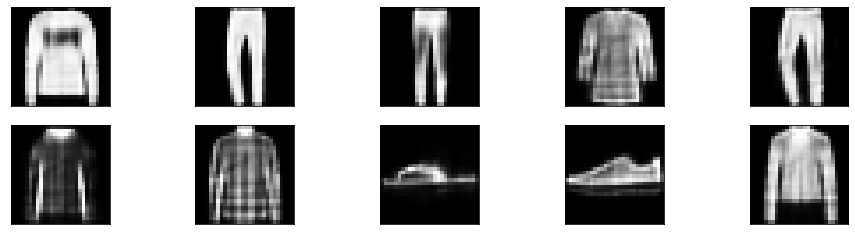

Compresion =  158.0


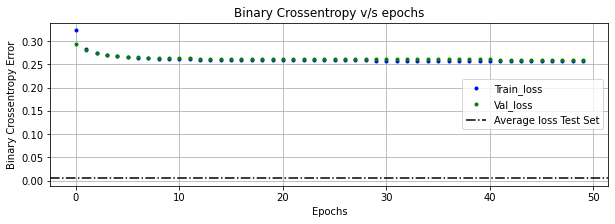

Elementos pasados por el Decoder


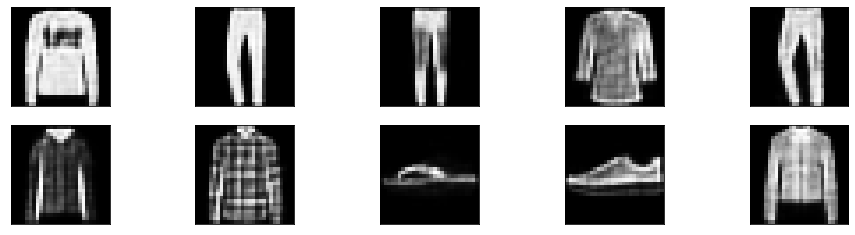

Compresion =  236.0


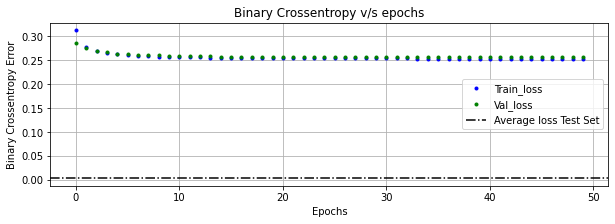

Elementos pasados por el Decoder


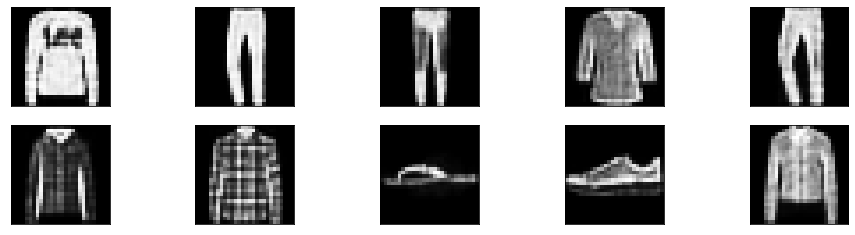

Compresion =  314.0


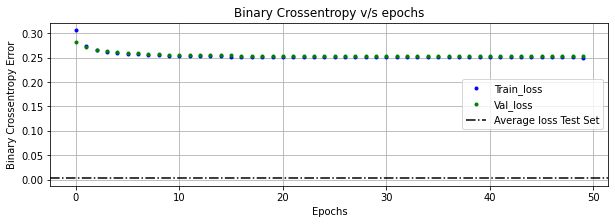

Elementos pasados por el Decoder


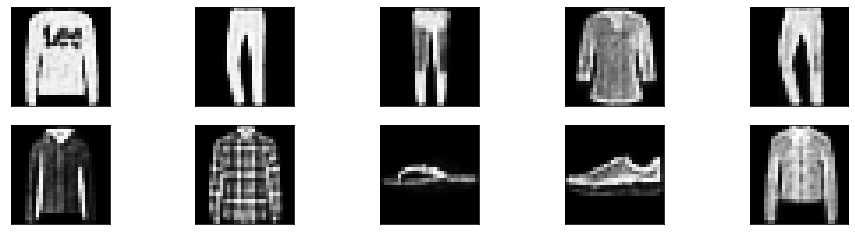

Compresion =  392.0


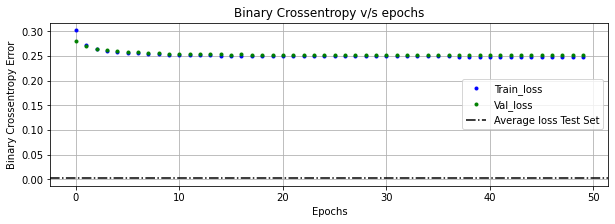

Elementos pasados por el Decoder


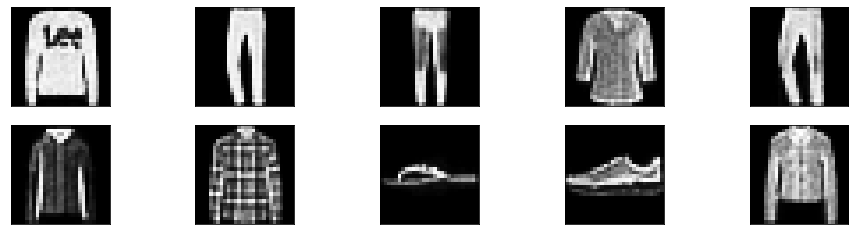

In [ ]:
max = (28**2)/2.0
min = 2
rango = np.linspace(min,max,6)

for i in range(6):
  comp_value = rango[i]
  print('Compresion = ',comp_value)
  autoencoder = Sequential()

  autoencoder.add(Dense(comp_value,activation='sigmoid')) # encoder
  
  autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder

  autoencoder.compile(optimizer=Adam(),loss='binary_crossentropy')
  history_1 = autoencoder.fit(x_tr_vector_scaled,x_tr_vector_scaled,epochs=50,validation_data=(x_val_vector_scaled,x_val_vector_scaled),verbose=0)

  y_pred=autoencoder.predict(x_tr_vector_scaled) # model.predict(x_test) returns numpy array
  test_batch_loss=tf.keras.losses.MSE(x_tr_vector_scaled, y_pred)
  test_loss_1_b_i=tf.math.reduce_mean(test_batch_loss).numpy()
  plt.rcParams["figure.figsize"]=[10,3]
  plt.title("Binary Crossentropy v/s epochs")
  plt.plot(history_1.history["loss"],"b.",label="Train_loss")
  plt.plot(history_1.history["val_loss"],"g.",label="Val_loss")
  plt.axhline(y=test_loss_1_b_i,color="k",linestyle="-.",label="Average loss Test Set")
  plt.xlabel("Epochs"),plt.ylabel("Binary Crossentropy Error")
  plt.legend(),plt.grid()
  plt.show()
  print("Elementos pasados por el Decoder")
  plt.rcParams["figure.figsize"]=[16,4]
  ix = 1
  for u in range(5):
    for v in range(2):
      ax = plt.subplot(2,5,ix)
      ax.set_xticks([])
      ax.set_yticks([])
      plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix].reshape(28,28),cmap='gray')
      ix += 1
  plt.show()

## 3.e) Deep autoencoder

Pruebe ahora con una arquitectura ligeramente más profunda. Para esto utilice a lo menos 3 capas de encoding, es decir, 3 capas que progresivamente reduzcan la dimensionalidad de la representación hasta una dimensión objetivo inicialmente igual a la mejor obtenida en la pregunta anterior. Utilice igualmente a lo menos 2 capas de decoding, que se encarguen de aumentar la dimensionaliad de la representación hasta alcanzar la dimensión de la imagen original. Note que las primeras capas no necesariamente deben tener menor dimensionalidad que la imagen, la dimensión relevante es aquella de la última capa de encoding. 

Una vez esté satisfecho con su arquitectura profunda, varíe la dimensión objetivo de la última capa de encoding, realizando una exploración similar a la pregunta anterior. Utilice gráficos y muestre algunas imágenes reconstruidas para complementar sus comentarios. 

**Preguntas:**

i) ¿Cómo aumenta el número de parámetros entrenables? ¿Aumenta el tamaño de la representación "comprimida"?

Dado que al tener una mayor cantidad de capas, el numero de parametros entrenables tambien se ve en aumento.

En relacion a la representacion, esta no se encuentra """mas""" comprimida, mas bien el proceso de concentracion de la informacion al poseer mas capas se ve menos forzado.

ii) ¿Puede obtener una representación de menor dimensionalidad que la encontrada en el item anterior sin perder calidad en las imagenes obtenidas?


Epoch 1/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4405 - val_loss: 0.3392
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3296 - val_loss: 0.3135
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3078 - val_loss: 0.3051
Epoch 4/20
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3011 - val_loss: 0.2998
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2967 - val_loss: 0.2969
Epoch 6/20
1875/1875 [==============================] - 8s 5ms/step - loss: 0.2935 - val_loss: 0.2946
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2922 - val_loss: 0.2933
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2903 - val_loss: 0.2916
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2893 - val_loss: 0.2903
Epoch 10/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.287

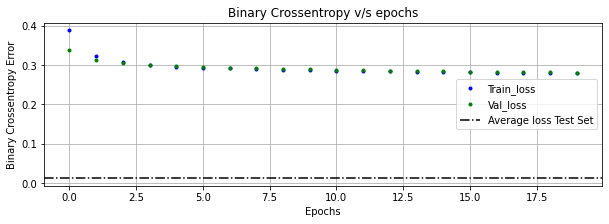

Elementos pasados por el Decoder


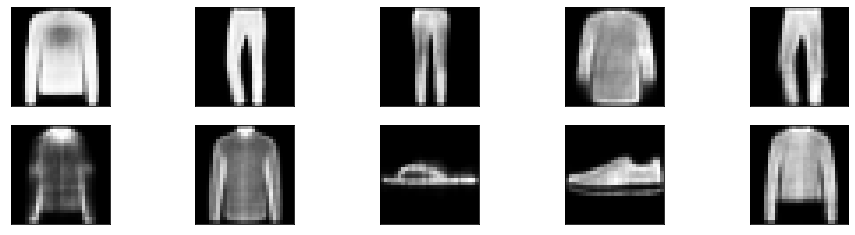

In [ ]:
autoencoder = Sequential()

autoencoder.add(Dense(236,activation='sigmoid')) # encoder 1

autoencoder.add(Dense(118,activation='sigmoid')) # encoder 2

autoencoder.add(Dense(59,activation='sigmoid')) # encoder 3

autoencoder.add(Dense(118,activation= 'sigmoid')) #decoder 1

autoencoder.add(Dense(28*28,activation= 'sigmoid')) #decoder 2

autoencoder.compile(optimizer=Adam(),loss='binary_crossentropy')
history_1 = autoencoder.fit(x_tr_vector_scaled,x_tr_vector_scaled,epochs=20,validation_data=(x_val_vector_scaled,x_val_vector_scaled),verbose=1)

y_pred=autoencoder.predict(x_tr_vector_scaled) # model.predict(x_test) returns numpy array
test_batch_loss=tf.keras.losses.MSE(x_tr_vector_scaled, y_pred)
test_loss_1_b_i=tf.math.reduce_mean(test_batch_loss).numpy()
plt.rcParams["figure.figsize"]=[10,3]
plt.title("Binary Crossentropy v/s epochs")
plt.plot(history_1.history["loss"],"b.",label="Train_loss")
plt.plot(history_1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=test_loss_1_b_i,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("Binary Crossentropy Error")
plt.legend(),plt.grid()
plt.show()
print("Elementos pasados por el Decoder")
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(5):
  for v in range(2):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(autoencoder.predict(x_val_vector_scaled)[ix].reshape(28,28),cmap='gray')
    ix += 1
plt.show()

In [ ]:
autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 236)               185260    
_________________________________________________________________
dense_20 (Dense)             (None, 118)               27966     
_________________________________________________________________
dense_21 (Dense)             (None, 59)                7021      
_________________________________________________________________
dense_22 (Dense)             (None, 118)               7080      
_________________________________________________________________
dense_23 (Dense)             (None, 784)               93296     
Total params: 320,623
Trainable params: 320,623
Non-trainable params: 0
_________________________________________________________________


## 3.f) Convolutional Autoencoder

Como hemos hasta ahora  utilizado una arquitectura fully connected, nuestra red no toma en cuenta la infomación local contenida en la proximidad de un pixel en la imagen. Como vimos en la tarea anterior, esta información podría ser crucial al momento de procesar imágenes. 

En este item deberá implementar un autoencoder convolucional. La sección de encoding de la red se creará de igual manera que las redes convolucionales creadas en la tarea 1. Puede utilizar capas de Max Pooling o Strides mayores a 1 para reducir la dimensionalidad en esta etapa. Tenga en mente como varía la dimensión de la imagen a lo largo del proceso. 

Para luego recuperar la dimensionalidad de la imagen original debemos utilizar una capa llamada usualmente como "Deconvolution Layer". Esta capa realiza el proceso inverso que aquel realizado por una capa convolucional, por lo cual utilizando por ejemplo `stride=2` puede duplicar la dimensionalidad de su input. 

Puede realizar la profundidad que desee, pero tome en cuenta que una mayor profundidad de la sección convolucional permite a la red reducir dimensionalidad más lentamente, sin "forzar" la compresión de las características. Note que para reconstruir la dimensión original puede usar `output_padding` para corregir problemas de paridad, entre otros. 

Puede igualmente optar por usar algun número de capas densas en el cuello de botella del autoencoder, usando al comienzo de esta una capa `Flatten` y al final de ella una capa `Reshape` (`keras.layers.Reshape(target_shape)`) para recuperar la bidimensionalidad.

¡No olvide que para entrenar esta red debe usar la versión bidimensional de los datos escalados!

Visualice que tan bien se comporta la convolución, en terminos de la función de pérdida y visualizando las imagenes reconstruidas. Compárese con la red densa. 

(60000, 28, 28) (10000, 28, 28)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 392)               154056    
_________________________________________________________________
reshape (Reshape)       

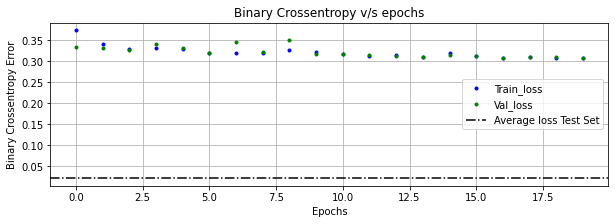

Elementos pasados por el Decoder


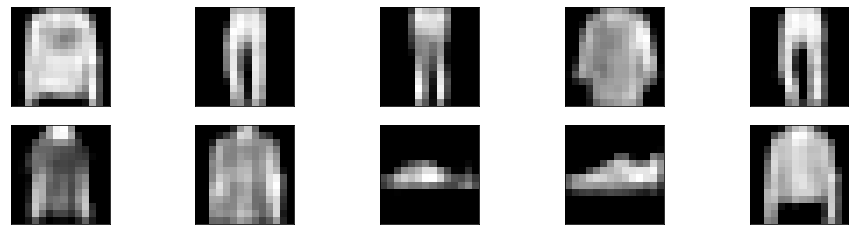

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
import tensorflow as tf
import numpy as np

print(np.shape(x_tr),np.shape(x_val))
x_tr_ch = x_tr.reshape(np.shape(x_tr)[0],np.shape(x_tr)[1],np.shape(x_tr)[2],1)/255.0
x_val_ch = x_val.reshape(np.shape(x_val)[0],np.shape(x_val)[1],np.shape(x_val)[2],1)/255.0
conv=Sequential()
#E
conv.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D(pool_size=(2,2)))

#BN
conv.add(Flatten())
conv.add(Dense(7*7*8,activation='sigmoid'))
conv.add(tf.keras.layers.Reshape((7, 7,8), input_shape=(7*7*8,)))

#D
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))

conv.summary()

conv.compile(optimizer=Adam(),loss='binary_crossentropy')
history_1 = conv.fit(x_tr_ch,x_tr_ch,epochs=20,validation_data=(x_val_ch,x_val_ch),verbose=1)



y_pred=conv.predict(x_tr_ch) # model.predict(x_test) returns numpy array
test_batch_loss=tf.keras.losses.MSE(x_tr_ch, y_pred)
test_loss_1_b_i=tf.math.reduce_mean(test_batch_loss).numpy()
plt.rcParams["figure.figsize"]=[10,3]
plt.title("Binary Crossentropy v/s epochs")
plt.plot(history_1.history["loss"],"b.",label="Train_loss")
plt.plot(history_1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=test_loss_1_b_i,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("Binary Crossentropy Error")
plt.legend(),plt.grid()
plt.show()
print("Elementos pasados por el Decoder")
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(5):
  for v in range(2):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(conv.predict(x_val_ch)[ix].reshape(28,28),cmap='gray')
    ix += 1
plt.show()

## 3.g) Denoising Autoencoder 

Otra utilidad que se le ha dado a los autoencoders es la posibilidad de utilizarlos para separar ruido de información. Para entrenar tal tipo de modelo, la idea es simple: utilizar como datos de entrada imagenes a las cuales se les ha agregado artificialmente ruido y como objetivo la imagen original sin ruido. 

Entrene alguna arquitectura de autoencoder que le parezca apropiada para la tarea utilizando algún tipo de ruido aleatorio. Puede utilizar cambios en valores de pixeles aleatoriamente, o por ejemplo "promediar" ponderadamente la imagen original con alguna otra imagen del dataset ligeramente modificada. Puede utilizar las librerías `random` de `numpy`. Sea creativo, puede crear el ruido que desee. Idealmente, considerando la naturaleza del problema que se buscaría modelar (eliminar ruido real de mediciones), la naturaleza del ruido agregado debe ser estocástica y no puede "repetirse" el mismo patrón de ruido a lo largo de todo el entrenamiendo, es decir, si agregó un ruido estocástico a cada imágen del conjunto, este proceso debe iterarse igualmente luego de cada época de entrenamiento, para evitar que la red aprenda un patrón especifico de ruido, si no aprenda realmente a diferenciar ruido sin información de la información suyaciente a la imagen. 

Una vez esté satisfecho con la red, muestre ejemplos de la imagen con ruido, la imagen original y la imagen reconstruida.

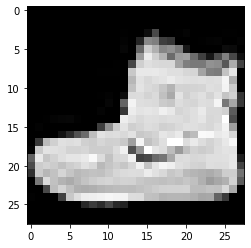

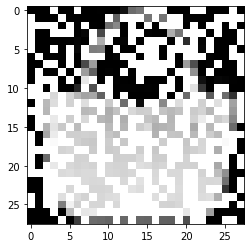

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 392)               154056    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 8)          

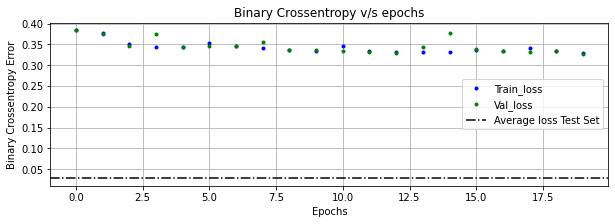

Elementos pasados por el Decoder


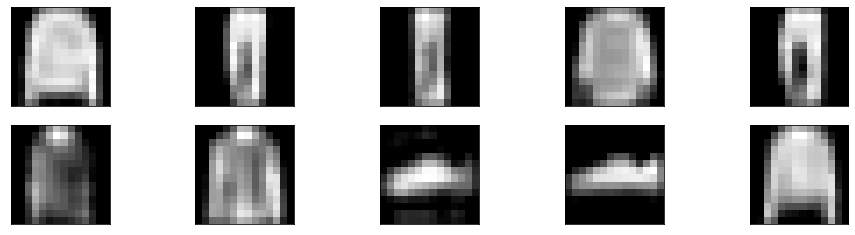

In [ ]:
def addsalt_pepper(img, SNR):
    img_ = img.copy()
    h, w, c = img_.shape
    mask = np.random.choice((0, 1, 2), size=(h,w,c), p=[SNR, (1 - SNR) / 2., (1 - SNR) / 2.])
    if random.random() < 0.5:
      img_[mask == 2] = 0
    else:
      img_[mask == 2] = 1
    return img_

plt.imshow(x_tr_ch[0].reshape(28,28),cmap='gray')
plt.show()
x_tr_ch_noise = np.copy(x_tr_ch)
x_val_ch_noise = np.copy(x_val_ch)
for i in range(np.shape(x_tr_ch_noise)[0]):
  x_tr_ch_noise[i] = addsalt_pepper(x_tr_ch_noise[i], 0.05)
for i in range(np.shape(x_val_ch_noise)[0]):
  x_val_ch_noise[i] = addsalt_pepper(x_val_ch_noise[i], 0.05)

conv=Sequential()
#E
conv.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu',input_shape=(28,28,1)))
conv.add(MaxPooling2D(pool_size=(2,2)))
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(MaxPooling2D(pool_size=(2,2)))

#BN
conv.add(Flatten())
conv.add(Dense(7*7*8,activation='sigmoid'))
conv.add(tf.keras.layers.Reshape((7, 7,8), input_shape=(7*7*8,)))

#D
conv.add(Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))
conv.add(Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='relu'))
conv.add(UpSampling2D((2, 2)))

conv.summary()

conv.compile(optimizer=Adam(),loss='binary_crossentropy')
history_1 = conv.fit(x_tr_ch_noise,x_tr_ch,epochs=20,validation_data=(x_val_ch_noise,x_val_ch),verbose=0)



y_pred=conv.predict(x_tr_ch_noise) # model.predict(x_test) returns numpy array
test_batch_loss=tf.keras.losses.MSE(x_tr_ch, y_pred)
test_loss_1_b_i=tf.math.reduce_mean(test_batch_loss).numpy()
plt.rcParams["figure.figsize"]=[10,3]
plt.title("Binary Crossentropy v/s epochs")
plt.plot(history_1.history["loss"],"b.",label="Train_loss")
plt.plot(history_1.history["val_loss"],"g.",label="Val_loss")
plt.axhline(y=test_loss_1_b_i,color="k",linestyle="-.",label="Average loss Test Set")
plt.xlabel("Epochs"),plt.ylabel("Binary Crossentropy Error")
plt.legend(),plt.grid()
plt.show()
print("Elementos pasados por el Decoder")
plt.rcParams["figure.figsize"]=[16,4]
ix = 1
for u in range(5):
  for v in range(2):
    ax = plt.subplot(2,5,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(conv.predict(x_val_ch_noise)[ix].reshape(28,28),cmap='gray')
    ix += 1
plt.show()

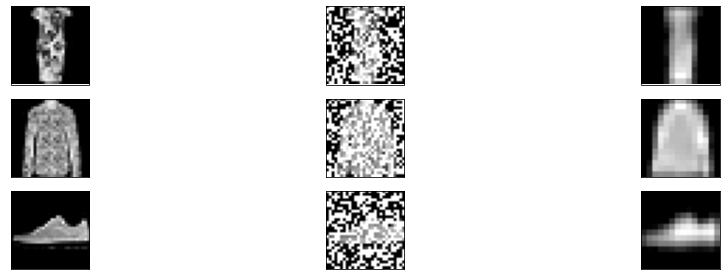

In [ ]:
c = 100
ix=1

for u in range(3):
  for v in range(3):
    ax = plt.subplot(3,3,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    if v == 0:
      plt.imshow(x_val_ch[c].reshape(28,28),cmap='gray')
      ix += 1
    if v == 1:
      plt.imshow(x_val_ch_noise[c].reshape(28,28),cmap='gray')
      ix += 1
    if v ==2:
      plt.imshow(conv.predict(x_val_ch_noise)[c].reshape(28,28),cmap='gray')
      ix += 1
  c+=1
plt.tight_layout()
plt.show()

## 3.h) Generación de imágenes

Otra utilización posible que podría darse, quizás, a los autoencoders, es utilizar los decoders para generar nuevas imágenes. La idea de esto sería considerar que la habilidad que tiene la sección decoder de generar una imágen a partir de una representación de menor dimensionalidad puede aprovecharse. 

Para esto, extraiga la sección de encoding y la sección de decoding de alguno de los autoencoders entrenados que prefiera. Obtenga los valores de la representación interna de las imágenes usando el encoder para calcularlos. Luego agréguele a esta representación algún ruido de su preferencia, y calcule la imágen resultante utilizando el decoder. ¿Qué observa? Muestre las imágenes obtenidas junto con otras imágenes de la misma categoría que la imágen que utilizó originalmente. Pruebe con distintos valores de ruido.

Pruebe también, por ejemplo, calcular la imágen obtenida al promediar las representaciones comprimidas de varias (o todas) las imágenes de una clase. Utilice el encoder para generar imágenes a partir de otros valores que se les ocurran y especule sobre el por qué la imágen obtenida se asimila o no a las imágenes del dataset. 

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model

def Encoder():
    input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format   
    e1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    e2 = MaxPooling2D((2, 2), padding='same')(e1)
    e3 = Conv2D(8, (3, 3), activation='relu', padding='same')(e2)
    e4 = MaxPooling2D((2, 2), padding='same')(e3)
    e5 = Conv2D(8, (3, 3), activation='relu', padding='same')(e4)
    e6 = MaxPooling2D((2, 2), padding='same')(e5)
    return Model(input_img, e6)


def Decoder():
    input_img = Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    d2 = UpSampling2D((2, 2))(d1)
    d3 = Conv2D(8, (3, 3), activation='relu', padding='same')(d2)
    d4 = UpSampling2D((2, 2))(d3)
    d5 = Conv2D(16, (3, 3), activation='relu')(d4)
    d6 = UpSampling2D((2, 2))(d5)
    d7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d6)
    return Model(input_img, d7)

e = Encoder()
d = Decoder()
# define input to the model:
x = Input(shape=(28, 28, 1))

# make the model:
autoencoder = Model(x, d(e(x)))

# compile the model:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_tr_ch,x_tr_ch,epochs=5,validation_data=(x_val_ch,x_val_ch),verbose=1)

Epoch 1/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.3630 - val_loss: 0.2985
Epoch 2/5
1875/1875 [==============================] - 97s 52ms/step - loss: 0.2949 - val_loss: 0.2926
Epoch 3/5
1875/1875 [==============================] - 97s 52ms/step - loss: 0.2891 - val_loss: 0.2891
Epoch 4/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2867 - val_loss: 0.2882
Epoch 5/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.2848 - val_loss: 0.2860


In [ ]:
pred = e.predict(x_tr_ch)
print(np.max(pred))
noise = np.random.normal(-0.5, 0.5, np.shape(pred))
dec = d.predict(pred+noise)

4.5383377


Ejemplo 1
Nueva Imagen


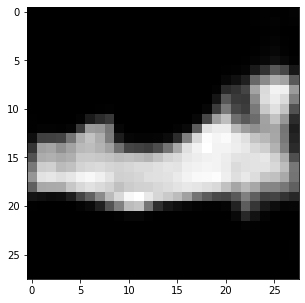

Imagen de Clase


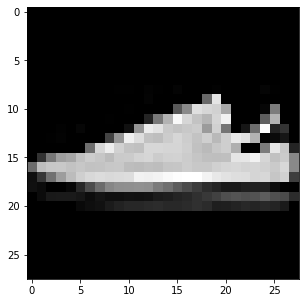

Ejemplo 2
Nueva Imagen


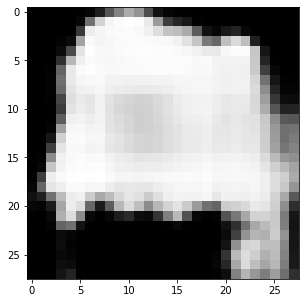

Imagen de Clase


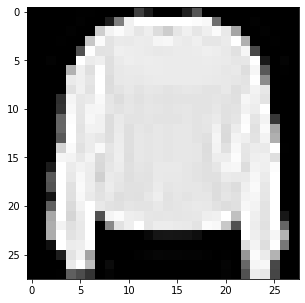

Ejemplo 3
Nueva Imagen


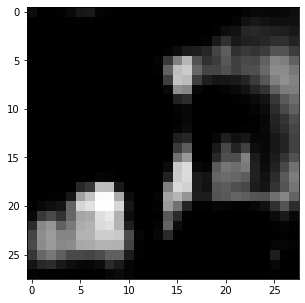

Imagen de Clase


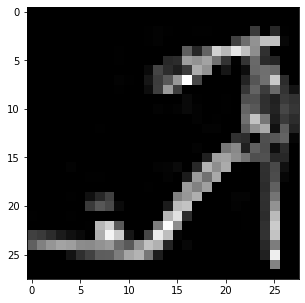

Ejemplo 4
Nueva Imagen


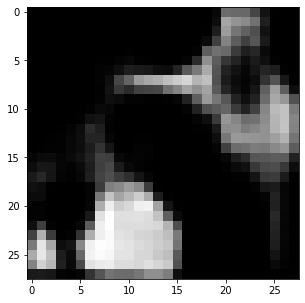

Imagen de Clase


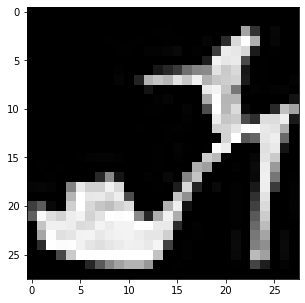

Ejemplo 5
Nueva Imagen


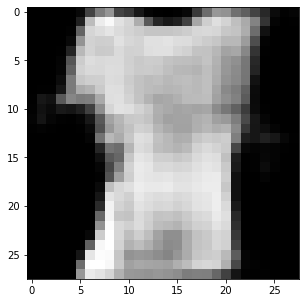

Imagen de Clase


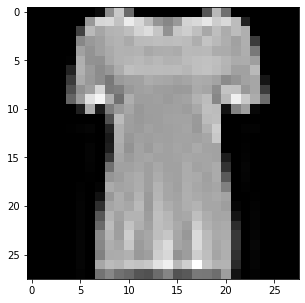

In [ ]:
rnd = round(random.random()*10)
for i in range(5):
  print('Ejemplo',i+1)
  plt.rcParams["figure.figsize"]=[5,5]
  print("Nueva Imagen")
  plt.imshow(dec[i+rnd].reshape(28,28),cmap='gray')
  plt.show()
  print("Imagen de Clase")
  plt.imshow(x_tr_ch[i+rnd].reshape(28,28),cmap='gray')
  plt.show()

# 4. GAN para MNIST 

Probablemente uno de los desarrollos recientes del area de las redes neuronales más interesantes son las GAN, o _Generative Adversarial Networks_. Estas han deslumbrado al mundo los últimos años generando resultados inesperados, como los llamados _deep fakes_ (https://www.youtube.com/watch?v=25GjijODWoI&ab_channel=Borked), caras no no existentes generadas artificialmente, entre muchas otras aplicaciones de las cuales las más creativas y divertidas son ampliamente divulgadas. Estos resultados nos dan cuenta que estas redes cuando son implementadas correctamente tienen la habilidad de realizar tareas muy especificas logrando desempeños que en logran incluso en algunos casos engañar a observadores humanos.

<img src="https://jrmerwin.github.io/deeplearning4j-docs/img/GANs.png" background="white">

Dependiendo del problema que uno quiera resolver las GAN no requieren datos etiquetados. Esto lo logran gracias a su estructura adversarial, es decir, donde simultaneamente se entrenan dos redes, una especializada en generar datos y otra red especializada en discriminar datos verdaderos de datos falsos, en su configuración más simple al menos. En esta parte de la tarea deberan generar una red de este tipo que genere dígitos que aparenten ser hechos a mano. Para esto utilizaremos las imágenes de entrenamiento del dataset MNIST que ya conocen.


## 4.a) Primera GAN

El código siguiente contiene todos los ingredientes para entrenar una red GAN, se encuentra áltamente comentada para su entendimiento. Usted deberá incluir funcionalidades al código, no incluya aún ninguna mejora a la arquitectura de las redes, esto se verá en el item 4.c). Las funcionalidades que debe añadir son las siguientes: 

i) Imprimir alguna medida del desempeño tanto del generador como del disciminador (por ejemplo f1-score, precision and recall o accuracy) a lo largo del entrenamiento. ¿Variaciones en esta medidas representan mejoras en nuestra red?

ii) Añadir gráficos de las entradas de data real con un título que indique la clasificación que está dando el discriminador a cada una de estas imágenes (Falsa|Real). El código entregado grafica tan solo las imágenes que genera el generador y la etiqueta que le está dando el discriminador (Falsa|Real).

**Recuero usar entorno de ejecución en GPU**

In [ ]:
from keras.datasets import mnist
import numpy as np
(x,_),(_,_) = mnist.load_data()
x = x.reshape((-1,28,28,1)).astype(np.float32)
x = x/255

In [ ]:
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
discriminator_net = Sequential() # Discriminador
discriminator_net.add(Conv2D(3, 3, strides=2, input_shape=x.shape[1:], padding='same')) #Recibe como entrada tanto imágenes generadas por el generador como imágenes del dataset
                                                                                        # de entrenamiento. Recuerden que los hiperparámetros de la red son intencionalmentes
                                                                                        # no idóneos.
discriminator_net.add(Flatten())    #Flatten para pasar a una neurona de capa densa
discriminator_net.add(Dense(1,activation='sigmoid',use_bias=False))   # La salida estará entre 0 y 1.

generator_net = Sequential() 
noise_size=50
generator_net.add(Dense(7*7*10, input_shape=[noise_size]))   # el generador recibirá como entrada ruido, el tamaño es arbitrario.
generator_net.add(Reshape((7,7,10)))    # Transforma la salida de la red densa unidimensional a tridimensional, las primeras dos pueden ser interpretadas como tamaño imágen
                                          # y la tercera como n° canales
generator_net.add(UpSampling2D())   # upsampling2d nos permite pasar de imágenes 7,7,10 a 14,14,10
generator_net.add(Conv2D(32, 5, padding='same')) # podemos añadir convolucionales dada la entrada a esta capa, la primera dimensión transformará la data
                                                      # desde 14,14,10 a 14,14,32
generator_net.add(UpSampling2D()) # pasamos de 14,14,32 a 28,28,32
generator_net.add(Conv2D(1, 6, padding='same',activation='sigmoid')) # hagamos lo que hagamos hay que asegurarse de obtener una salida 28,28,1 como es el caso en esta arquitectura

discriminator = Sequential() # Compilamos el discriminador, sin embargo debemos crear la red auxiliar a discriminator_net, para poder entrenarla independiente del generator
discriminator.add(discriminator_net)
discriminator.compile(loss='binary_crossentropy', optimizer = RMSprop(lr=1e-2), metrics=['acc']) # compilamos con binary cross entropy

gan = Sequential() # GAN contendrá al generador y al discriminador en serie
gan.add(generator_net) # añadimos inicialmente el generador
for layer in discriminator_net.layers: # y luego el discriminador 
    layer.trainable = False # nos preocupamos de dejar esta capa no entrenable por el compilador, puesto este discrimiador se entrenará con la data real para identificar real|fake
gan.add(discriminator_net) # añadimos las capas ya modificadas para no ser entrenadas
gan.compile(loss='binary_crossentropy', optimizer = RMSprop(lr=1e-2), metrics=['acc']) #compilamos

In [ ]:
batch_size=128 # tamaño del batch
plt.rcParams["figure.figsize"]=[20,4]
for epoch in range(20): #epochs a realizar
    for batch in range(int(x.shape[0]/batch_size)): #n° de batchs a realizar según el tamaño batch_size
      # train discriminator
      ix = np.random.randint(0, x.shape[0], batch_size) # generamos índices para samplear imágenes del dataset, sampleamos batch_size=128 datos
      x_real = x[ix]  # seleccionamos las imágenes
      noise = np.random.rand(noise_size * batch_size) # generamos ruido, según el tamaño de la entrada de nuestro generador
      noise = noise.reshape((batch_size, noise_size)) # reshape (batch_size,noise_size) sized noise
      x_false = generator_net.predict(noise) # generamos imágenes fake según el ruido
      y_real= np.ones((batch_size, 1)) # etiquetas real
      y_false = np.zeros((batch_size, 1)) #etiquetas fake
      x_train = np.concatenate((x_real, x_false)) # x_train-> imágenes reales + imágenes fakes
      y_train = np.concatenate((y_real, y_false)) # y_train-> etiquetas reales + etiquetas fakes
      response_dis = discriminator.train_on_batch(x_train, y_train) #train discriminator
      # train generator
      noise2 = np.random.rand(noise_size * batch_size) # generamos ruido nuevamente según el tamaño de la entrada de nuestro generador
      noise2 = noise2.reshape((batch_size, noise_size)) # reshape (batch_size,noise_size) sized noise
      response_gen = gan.train_on_batch(noise2 , np.ones((batch_size, 1))) # output is 1, as generator needs to convine discriminator (trainable false) w/ fake images from noise
      if batch%(200)==0: # cada cuánto plotear es ajustable
          # plot random generated images, discriminator image inputs and outputs, and losses and accuracies
          plt.suptitle("Generator generated images", y=1.2,size=22)
          for i in range(10):
            plt.subplot(2, 5, 1 + i)
            plt.title("Discriminator says:\n"+ ["Fake","Real"][int(np.round(discriminator.predict(x_false[i:i+1, :, :, :])[0,0],0))])
            plt.axis('off')
            plt.imshow(x_false[i, :, :, 0], cmap='gray_r')
          plt.tight_layout()
          plt.show()
          print("-"*120)
          
          # plt.suptitle("Real images", y=1.2,size=22)
          # for i in range(10):
          #   plt.subplot(2, 5, 1 + i)
            # plt.title("Discriminator says:\n"+ ["Fake","Real"])
            # plt.imshow(,cmap='gray_r')

## 4.b) Mejora de GAN.

Utilizando el código modificado en el punto 4.b y lo aprendido durante el ramo. Modifique la arquitectura de la red neuronal a modo de obtener imágenes fake sean convincentes. Adicionalmente responda/comente según lo que observa durante el entrenamiento de la red neuronal.

* Explicar el comportamiento de la evolución de ambos desempeños y por qué no necesariamente esos valores representan que la red alcance su cometido
* Describir, teórica o práctiamente, que ocurriría si la red generadora no pudiera por algún motivo (divergencia en entrenamiento, excesivo _underfitting_, etc) generar imágenes razonables.
* Describir la contraparte de lo que ocurriría si la red discriminadora no pudiera aprender a diferenciar imagenes reales de ruido aleatorio.


Una vez teniendo una red entrenada a completitud, muestre varias imagenes generadas. ¿Se logra obtener imágenes convincentes?. Igualmente con la red entrenada, guarde el ruido aleatorio que origina dos números reconocibles distintos. ¿Qué ocurre si vemos las imagenes generadas por el generador al entregarle el vector del promedio entre los dos puntos?


## Pregunta **Bonus**

* Proponga o investigue como realizaría las siguientes tareas:
    * A partir de una base de datos de imagenes RGB, entrenar una GAN que genere imágenes a color convincentes a partir de imagenes en blanco y negro, es decir que deduzca el color a partir de imagenes en blanco y negro.
    * A partir de una base de datos de cuadros de paisajes reales y las fotos correspondientes al cuadro, entrenar una GAN que permita transformar fotografias a cuadros y viceversa (puede utilizar más de 2 redes)
    * Proponga un problema que les parezca interesante y una estructura de GAN que le permitiría resolverlo